## 1. Next-Word Prediction using MLP [5 marks]
In this question, you will extend the next-character prediction notebook (discussed in class) to a next-word prediction problem.That is you will create a MLP based text generator. You will train the model, visualize learned word embeddings, and finally deploy a Streamlit app for interactive text generation. It is recommended to refer to Andrej Karpathy’s blog post on the [Effectiveness of RNNs](https://karpathy.github.io/2015/05/21/rnn-effectiveness/).

You must complete this task for two datasets: one from Category I (Natural Language) and one from Category II (Structured/Domain Text).



#### Note:



We trained it on Lightning.ai

![](./image.png)

![](./image-2.png)

### Imports and Helpers


In [1]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from collections import Counter
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
from sklearn.manifold import TSNE
import itertools
import time


In [2]:
file_path = 'question1_datasets/sherlock.txt' 
ctx_window = 6
epochs = 500
batch_size = 4096
test_size = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def make_serializable(obj):
    if isinstance(obj, nn.Module):
        return obj.__class__.__name__
    if isinstance(obj, (list, tuple)):
        return [make_serializable(x) for x in obj]
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    return obj


Using device: cuda


In [28]:
def visualize_embeddings(model, stoi):
    word_groups = {
        'names': ['holmes', 'watson', 'adler', 'lestrade'],
        'pronouns': ['he', 'she', 'his', 'her', 'they', 'them', 'you', 'me'],
        'verbs': ['see', 'saw', 'go', 'went', 'think', 'thought', 'is', 'was', 'are', 'were'],
        'objects': ['pipe', 'violin', 'door', 'window', 'street', 'house', 'cab'],
        'concepts': ['death', 'life', 'love', 'fear', 'crime', 'case', 'mystery'],
        'synonyms': ['observe', 'examine', 'see', 'look', 'deduce', 'infer', 'crime', 'case'],
        'antonyms': ['good', 'evil', 'quick', 'slow', 'true', 'false', 'innocent', 'guilty']
    }
    
    synonym_pairs = [('observe', 'thought'), ('deduce', 'infer'), ('crime', 'case'), ('examine','mystery')]
    antonym_pairs = [('good', 'evil'), ('death', 'life'), ('quick', 'slow'), ('true', 'false'), ('innocent', 'guilty')]

    words_to_plot = []
    group_labels = []
    for group, words in word_groups.items():
        for word in words:
            if word in stoi: 
                if word not in words_to_plot: 
                    words_to_plot.append(word)
                    group_labels.append(group)
            else:
                print(f"Note: Word '{word}' not in vocabulary, skipping.")

    if not words_to_plot:
        print("No words to plot. Check your word lists against the vocabulary.")
        return

    all_embeddings = model.embedding.weight.data.cpu().numpy()
    word_indices = [stoi[word] for word in words_to_plot]
    selected_embeddings = all_embeddings[word_indices]
    
    tsne = TSNE(n_components=2, random_state=42, 
                init='pca', max_iter=3000)
    embeddings_2d = tsne.fit_transform(selected_embeddings)
    
    word_to_coord = {word: embeddings_2d[i] for i, word in enumerate(words_to_plot)}

    plt.figure(figsize=(20, 16))
    unique_groups = list(word_groups.keys())
    colors = plt.cm.get_cmap('tab10', len(unique_groups))
    group_to_color = {group: colors(i) for i, group in enumerate(unique_groups)}
    
    for i, word in enumerate(words_to_plot):
        x, y = embeddings_2d[i]
        group = group_labels[i]
        color = group_to_color[group]
        plt.scatter(x, y, color=color, alpha=0.8, s=100)
        plt.annotate(word, (x, y), ha='center', va='bottom', fontsize=10)
    
    for w1, w2 in synonym_pairs:
        if w1 in word_to_coord and w2 in word_to_coord:
            coord1 = word_to_coord[w1]
            coord2 = word_to_coord[w2]
            plt.plot([coord1[0], coord2[0]], [coord1[1], coord2[1]], 'g-', alpha=0.6, linewidth=1.5)

    for w1, w2 in antonym_pairs:
        if w1 in word_to_coord and w2 in word_to_coord:
            coord1 = word_to_coord[w1]
            coord2 = word_to_coord[w2]
            plt.plot([coord1[0], coord2[0]], [coord1[1], coord2[1]], 'r--', alpha=0.6, linewidth=1.5)

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=group,
                                  markerfacecolor=group_to_color[group], markersize=12)
                       for group in unique_groups]
    
    legend_elements.append(plt.Line2D([0], [0], color='green', lw=2, label='Synonym Pair'))
    legend_elements.append(plt.Line2D([0], [0], color='red', lw=2, linestyle='--', label='Antonym Pair'))

    plt.legend(handles=legend_elements, title="Word Groups & Relations", fontsize='large')
    plt.title('t-SNE Visualization of Word Embeddings', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()


## Category 1: Sherlock

### 1.1 Preprocessing and Vocabulary Construction [0.5 mark]

In [5]:
def make_dataset(filepath: str, ctx_window: int):
    # Read and Clean Text

    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()

    text = re.sub(r'[^a-zA-Z0-9 \.]', ' ', text)  # Keep letters, numbers, space, period
    text = text.lower()
    text = " ".join(text.split()) # remove multiple whitespaces

    all_words = text.split()

    word_counts = Counter(all_words)
    most_common = word_counts.most_common(10)

    least_common = word_counts.most_common()[:-11:-1]

    unique_words_set = set(all_words)
    vocab = sorted([
        w for w in unique_words_set
        if 1 < len(w) < 22 and w.isalpha()
    ])

    stoi = {s: i + 1 for i, s in enumerate(vocab)}
    stoi['.'] = 0  # Use '.' as the unknown token.
    
    itos = {i: s for s, i in stoi.items()}
    X, Y = [], []

    for i in range(ctx_window, len(all_words)):
        context = all_words[i-ctx_window:i]
        target = all_words[i]

        context_ix = [stoi.get(word, stoi['.']) for word in context]
        target_ix = stoi.get(target, stoi['.'])

        X.append(context_ix)
        Y.append(target_ix)

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)

    return X, Y, stoi, itos, most_common, least_common


In [ ]:
X,Y,stoi,itos,most_common,least_common = make_dataset(file_path,ctx_window)
vocab_size = len(stoi)
X_train, X_val, Y_train, Y_val = train_test_split(
    X.cpu(), Y.cpu(), test_size=test_size, random_state=42
)

print(list(map(lambda x:itos.get(x.item(),'.'),X_train[1232])),itos.get(Y_train[1232].item(),'.'))
print()
print(f"Most Common:\n{'\n'.join([(i[0] + "\t: " + str(i[1])) for i in most_common])}\n")
print(f"Least Common:\n{'\n'.join([(i[0] + " : " + str(i[1])) for i in least_common])}")

['george', 'meredith', 'if', 'you', 'please', 'and'] we

Most Common:
the	: 5822
and	: 3085
i	: 3010
to	: 2816
of	: 2776
a	: 2696
in	: 1813
that	: 1744
it	: 1600
you	: 1481

Least Common:
ebooks. : 1
newsletter : 1
subscribe : 1
includes : 1
pg : 1
edition. : 1
necessarily : 1
included. : 1
support. : 1
network : 1


### 1.2 Model Design and Training [1 marks]

#### Grid Search to test out different parameters

In [ ]:
class MLPTextGenerator(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        context_window,
        dropout_rate=0.5,
        activation=nn.ReLU(),
    ):
        super(MLPTextGenerator, self).__init__()
        self.context_window = context_window
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.fc1 = nn.Linear(context_window * embedding_dim, hidden_dim)
        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x: (batch_size, context_window)
        embedded = self.embedding(x)
        # embedded: (batch_size, context_window, embedding_dim)

        flattened = embedded.view(
            -1, self.context_window * self.embedding.embedding_dim
        )
        # flattened: (batch_size, context_window * embedding_dim)

        out = self.activation(self.fc1(flattened))
        out = self.dropout(out)
        out = self.fc2(out)

        # output: (batch_size, vocab_size)
        return out


def generate_text(model, stoi, itos, ctx_window, prompt, max_length=20, temperature=1):
    model.eval()

    prompt = prompt.lower().replace(".", " . ")
    prompt = re.sub(r"[^a-z0-9 \.]", " ", prompt)
    words = prompt.split()

    pad_index = stoi["."]
    context = [pad_index] * ctx_window
    for word in words:
        context.pop(0)
        context.append(stoi.get(word, pad_index))

    context_idx = torch.tensor([context], dtype=torch.long).to(device)
    generated_words = []

    with torch.no_grad():
        for _ in range(max_length):
            output = model(context_idx)
            probs = F.softmax(output/temperature, dim=1)
            next_word_idx = torch.multinomial(probs, num_samples=1).item()

            if next_word_idx == pad_index:
                break

            word = itos.get(next_word_idx, ".")
            generated_words.append(word)

            context_idx = torch.roll(context_idx, -1, dims=1)
            context_idx[0, -1] = next_word_idx

    return prompt + " " + " ".join(generated_words)

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device):    
    loss_tr = []
    loss_val = []
    va = 0
    vl = 0
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        # Train loop
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} ", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        loss_tr.append(epoch_train_loss/len(train_loader))
        
        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                try:
                    loss = criterion(outputs, yb)
                except RuntimeError as e:
                    print("Failed batch target min/max:", yb.min().item(), yb.max().item())
                    raise
                # loss = criterion(outputs, yb)
                epoch_val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total_preds += yb.size(0)
                correct_preds += (predicted == yb).sum().item()
        
        val_accuracy = (correct_preds / total_preds) * 100 if total_preds > 0 else 0
        if va < val_accuracy:
            va = val_accuracy
            vl = epoch_val_loss/len(val_loader)
            
        loss_val.append(epoch_val_loss/len(val_loader))
    return vl, va, loss_val,loss_tr

In [ ]:

param_grid = {
        'EMBEDDING_DIM': [32,64],
        'HIDDEN_DIM': [256, 512, 1024],
        'DROPOUT_RATE': [0.2, 0.4],
        'WEIGHT_DECAY': [1e-5, 1e-4],
        'ACTIVATION': [nn.ReLU(),nn.Tanh()]
    }
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

results = []
for i, params in enumerate(param_combinations):
        start_time = time.time()
        print(f"\n--- Running Combo {i+1}/{len(param_combinations)} ---")
        print(f"Params: {params}")
        
        # initialize Model, Loss, Optimizer with current params
        print("context_window =", ctx_window)
        print("DEVICE =", device)
        model = MLPTextGenerator(
            vocab_size=vocab_size,
            embedding_dim=params['EMBEDDING_DIM'],
            hidden_dim=params['HIDDEN_DIM'],
            context_window=ctx_window,
            dropout_rate=params['DROPOUT_RATE'],
            activation= params['ACTIVATION']
        ).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(
            model.parameters(),
            lr=0.001,
            weight_decay=params['WEIGHT_DECAY']
        )
        
        val_loss, val_acc,loss_val, loss_train = train_model(
            model,
            train_loader,
            val_loader,
            optimizer,
            criterion,
            epochs,
            device
        )
        
        end_time = time.time()
        duration = end_time - start_time
        
        print(f"Combo {i+1} Result: Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {duration:.1f}s")
        
        results.append({
            'params': params,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'duration_sec': duration,
            'train_loss':loss_train,
            'val_loss':loss_val,
        })
        
        del model
        del optimizer
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

results.sort(key=lambda x:min(x['val_loss']))


--- Running Combo 1/48 ---
Params: {'EMBEDDING_DIM': 32, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'ACTIVATION': ReLU()}
vocab_size = 8151
context_window = 5
DEVICE = cuda
                                                                     
Combo 1 Result: Val Loss: 8.1112, Val Acc: 13.52%, Time: 67.2s

--- Running Combo 2/48 ---
Params: {'EMBEDDING_DIM': 32, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'ACTIVATION': Tanh()}
vocab_size = 8151
context_window = 5
DEVICE = cuda
                                                                     
Combo 2 Result: Val Loss: 6.1202, Val Acc: 13.86%, Time: 66.2s

--- Running Combo 3/48 ---
Params: {'EMBEDDING_DIM': 32, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'ACTIVATION': ReLU()}
vocab_size = 8151
context_window = 5
DEVICE = cuda
                                                                     
Combo 3 Result: Val Loss: 8.2803, Val Acc: 13.54%, Time: 66.4s

--- Running Combo

In [ ]:
print("Top 5 Best Performing Models (by min Validation Loss):")
for i, res in enumerate(results[:5]):
    print(f"{i+1}:")
    print(f"  Acc: {res['val_acc']:.2f}%")
    print(f"  Params: {res['params']}")
    print(f"  Time: {res['duration_sec']:.1f}s\n")

with open('grid_search_results.json','w') as f:
    f.write(json.dumps(make_serializable(results),indent=4))

Top 5 Best Performing Models (by Validation Accuracy):
1:
  Acc: 14.16%
  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'ACTIVATION': Tanh()}
  Time: 70.3s

2:
  Acc: 14.00%
  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'ACTIVATION': Tanh()}
  Time: 71.2s

3:
  Acc: 14.73%
  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 0.0001, 'ACTIVATION': Tanh()}
  Time: 72.8s

4:
  Acc: 14.54%
  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 1e-05, 'ACTIVATION': Tanh()}
  Time: 69.1s

5:
  Acc: 13.86%
  Params: {'EMBEDDING_DIM': 32, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'ACTIVATION': Tanh()}
  Time: 66.2s



Using the best model :

  Params: {'EMBEDDING_DIM': 64, 'HIDDEN_DIM': 256, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'ACTIVATION': Tanh()}


In [ ]:
model = MLPTextGenerator(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_dim=256,
    context_window=ctx_window,
    dropout_rate=0.4,
    activation= nn.Tanh()
).to(device)
        
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0001
)


--- Generating t-SNE Embedding Visualization ---


C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_18944\878440390.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


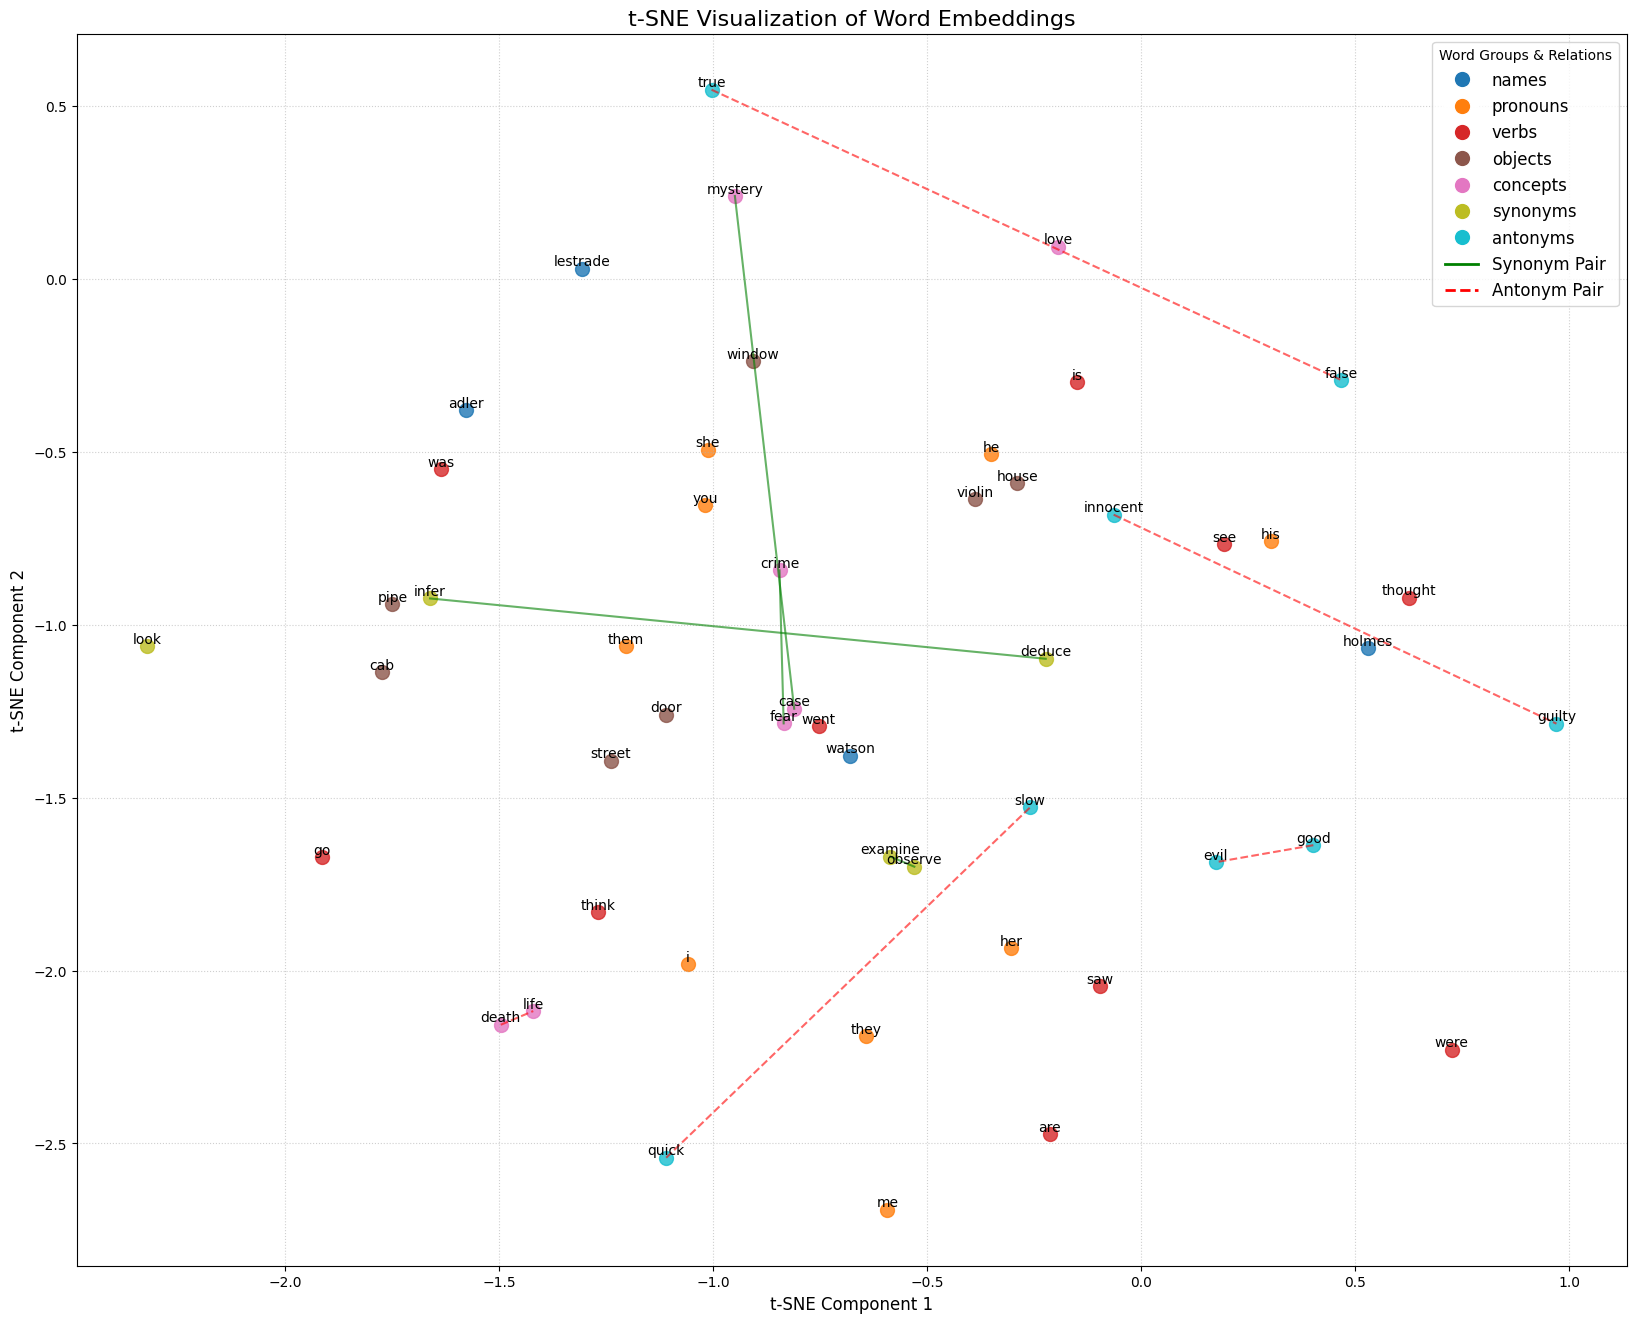

In [171]:
visualize_embeddings(model,stoi)

In [ ]:
EPOCHS = 20
val_loss, val_acc,loss_val, loss_train = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    EPOCHS,
    device
)


--- Generating t-SNE Embedding Visualization ---


C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_18944\878440390.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


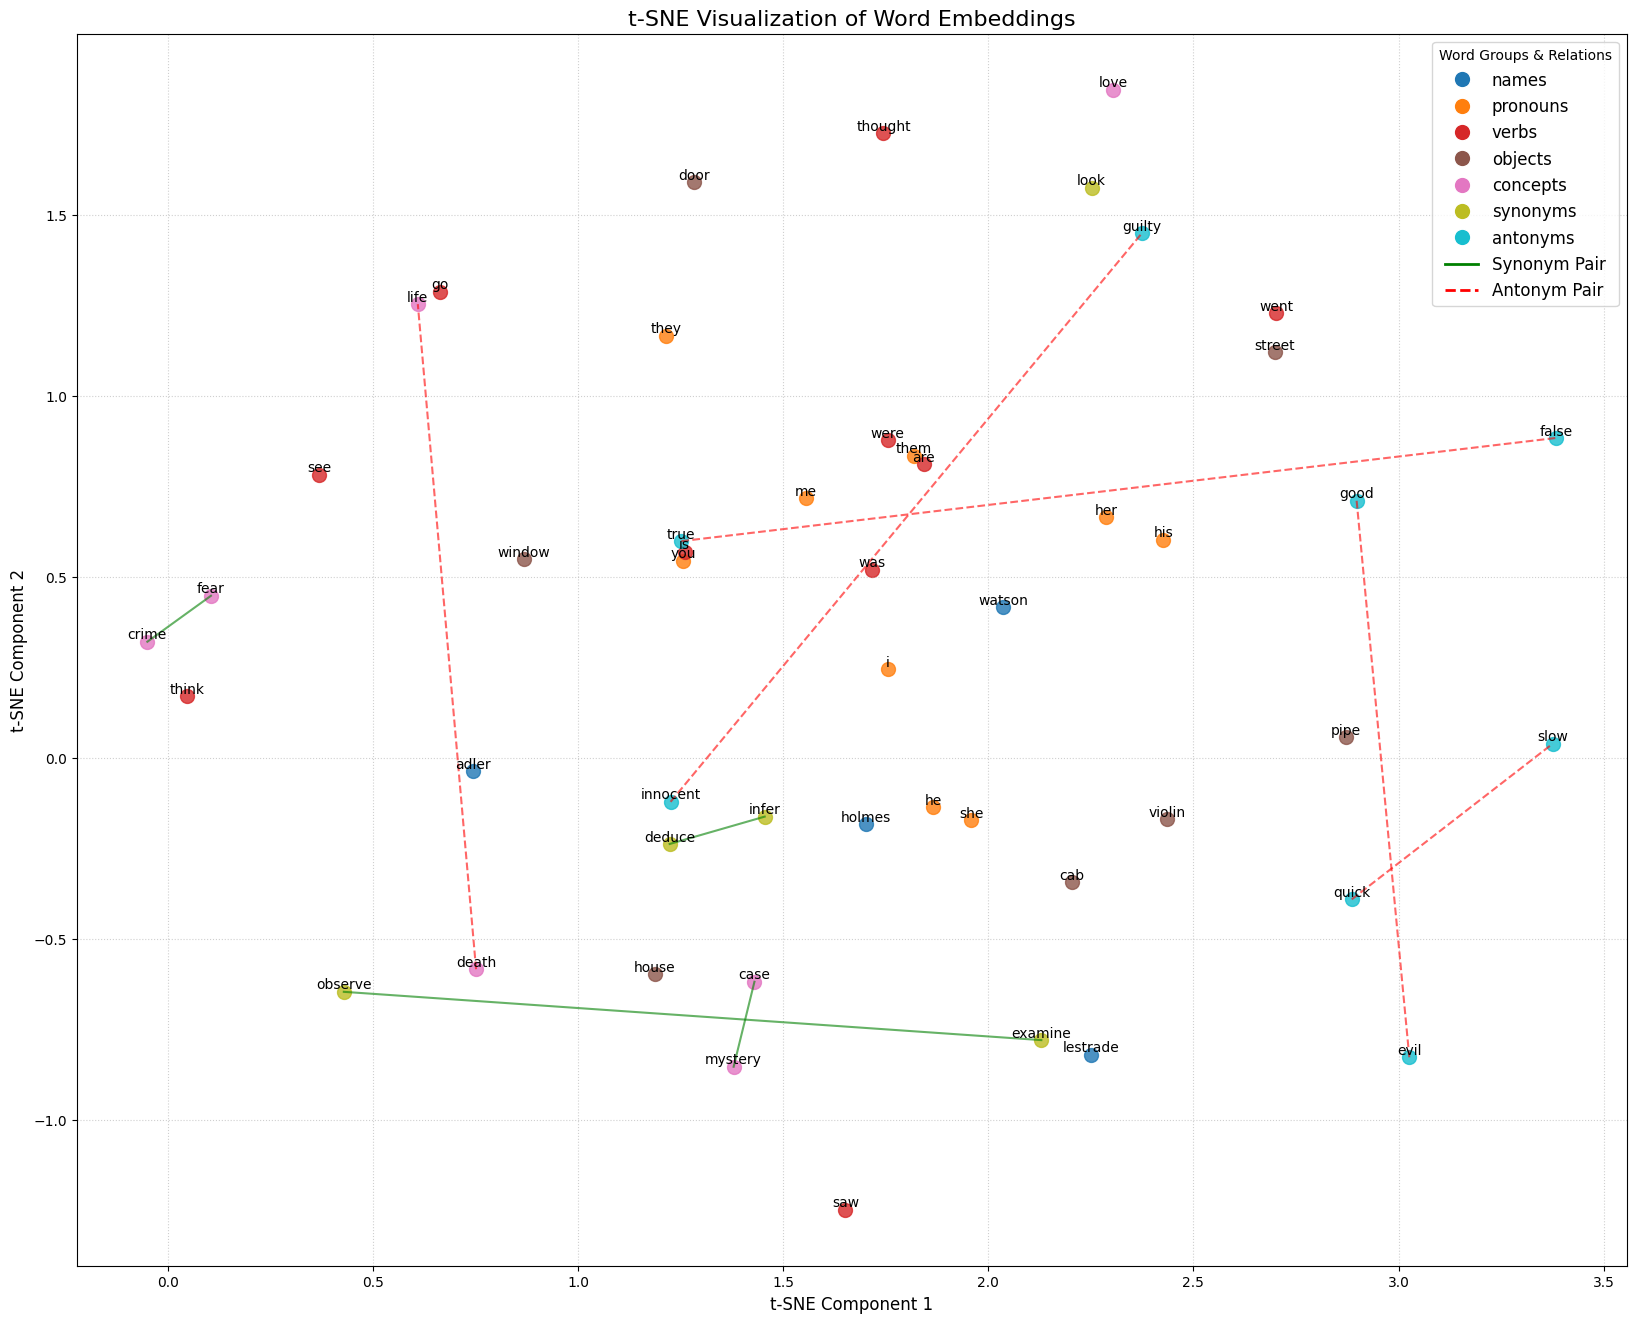

In [164]:
visualize_embeddings(model,stoi)

Best Validation Accuracy: 10.88%

Saved loss plot to 'loss_plot.png'


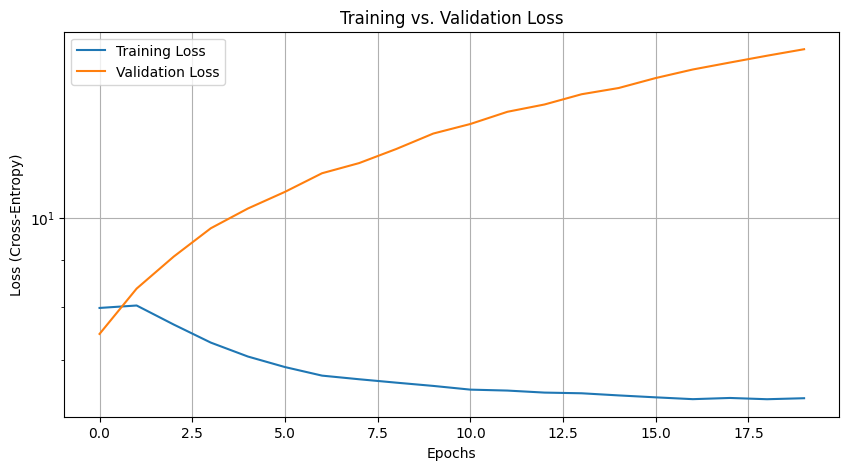

In [ ]:
print(f"Best Validation Accuracy: {val_acc:.2f}%")
plt.figure(figsize=(10, 5))
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Validation Loss')
plt.yscale('log')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')

The train loss saturates, lets increase the number of hidden neurons

#### Final Model

In [43]:
def generate_text(
    model,
    itos,
    stoi,
    ctx_window,
    device,
    prompt='',
    max_new_words = 100,
    temperature  = 1.0,
):
    if temperature <= 0:
        print("Warning: Temperature must be > 0. Setting to 1.0.")
        temperature = 1.0
    model.eval()
    prompt_words = prompt.split()
    context_indices = [
        stoi.get(word, 0) for word in prompt_words
    ]
    context = context_indices[-ctx_window:]
    if len(context) < ctx_window:
        context = [0] * (ctx_window - len(context)) + context

    generated_words = []

    with torch.no_grad():
        for _ in range(max_new_words):
            context_tensor = torch.tensor(context).view(1, -1).to(device)
            logits = model(context_tensor)
            scaled_logits = logits / temperature

            distribution = torch.distributions.categorical.Categorical(
                logits=scaled_logits
            )
            next_token_idx = distribution.sample().item()
            word = itos.get(next_token_idx)
            if word is None or word == "." or next_token_idx == 0:
                break

            generated_words.append(word)
            context = context[1:] + [next_token_idx]
    model.train()
    full_text = prompt_words + generated_words
    return " ".join(full_text)

In [30]:
embedding_dim = 64
hidden_dim = 768
class MLPTextGenerator(nn.Module):
    def __init__(self, ctx_window, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # embedding layer
        self.fc1 = nn.Linear(embedding_dim * ctx_window, hidden_dim)  # first hidden layer
        self.act = nn.Tanh()  # activation function
        self.fc2 = nn.Linear(hidden_dim, vocab_size)  # output layer

    def forward(self, x):
        embeds = self.embedding(x)
        embeds = embeds.view(x.shape[0], -1)  # flatten embeddings
        out = self.fc1(embeds)  # fully connected layer
        out = self.act(out)  # relu activation
        out = self.fc2(out)  # output
        return out

In [31]:
model = MLPTextGenerator(ctx_window, vocab_size, embedding_dim, hidden_dim).to(device)

In [163]:
for param_name, param in model.named_parameters():
    print(f"{param_name}: {param.shape}")

embedding.weight: torch.Size([7606, 64])
fc1.weight: torch.Size([768, 384])
fc1.bias: torch.Size([768])
fc2.weight: torch.Size([7606, 768])
fc2.bias: torch.Size([7606])


In [70]:
print(generate_text(model,itos,stoi,ctx_window,device,'',30,temperature=2))

quite afraid that it will take wiser heads than yours or mine not spoken before the


In [39]:
# Training!!!

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.001)
model.to(device)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val, Y_val = X_val.to(device), Y_val.to(device)

train_loss_per_epoch = []
val_loss_per_epoch = []
val_acc_per_epoch = []

for epoch in tqdm(range(epochs), desc="Epochs", position=0):
    model.train()
    epoch_train_loss = 0.0
    for i in tqdm(range(0, X_train.shape[0], batch_size), 
                  desc=f"Training Epoch {epoch}", 
                  leave=False, 
                  position=1):

        x = X_train[i:i+batch_size]
        y = Y_train[i:i+batch_size]

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        outputs = model(X_val)
        val_loss = loss_fn(outputs, Y_val).item()
        _, predicted = torch.max(outputs, 1)
        val_acc = (predicted == Y_val).float().mean().item() * 100
    
    train_loss_per_epoch.append(epoch_train_loss)
    val_acc_per_epoch.append(val_acc)
    val_loss_per_epoch.append(val_loss)
    if epoch % 50 == 0:
        tqdm.write(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {epoch_train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_acc:.2f}%"
        )

Epochs:   0%|          | 1/500 [00:00<07:21,  1.13it/s]

Epoch 000 | Train Loss: 34.5913 | Val Loss: 6.6605 | Val Acc: 12.47%


Epochs:  10%|█         | 51/500 [00:35<05:24,  1.38it/s]

Epoch 050 | Train Loss: 1.7473 | Val Loss: 9.0447 | Val Acc: 9.86%


Epochs:  20%|██        | 101/500 [01:12<04:36,  1.44it/s]

Epoch 100 | Train Loss: 0.4644 | Val Loss: 9.9551 | Val Acc: 9.60%


Epochs:  30%|███       | 151/500 [01:48<04:18,  1.35it/s]

Epoch 150 | Train Loss: 0.2643 | Val Loss: 10.4853 | Val Acc: 9.71%


Epochs:  40%|████      | 201/500 [02:26<03:44,  1.33it/s]

Epoch 200 | Train Loss: 0.1943 | Val Loss: 10.8691 | Val Acc: 9.64%


Epochs:  50%|█████     | 251/500 [03:02<02:57,  1.40it/s]

Epoch 250 | Train Loss: 0.1596 | Val Loss: 11.1879 | Val Acc: 9.62%


Epochs:  60%|██████    | 301/500 [03:39<02:27,  1.35it/s]

Epoch 300 | Train Loss: 0.1395 | Val Loss: 11.4594 | Val Acc: 9.55%


Epochs:  70%|███████   | 351/500 [04:17<01:45,  1.41it/s]

Epoch 350 | Train Loss: 0.1260 | Val Loss: 11.7032 | Val Acc: 9.70%


Epochs:  80%|████████  | 401/500 [04:52<01:06,  1.48it/s]

Epoch 400 | Train Loss: 0.1172 | Val Loss: 11.9215 | Val Acc: 9.65%


Epochs:  90%|█████████ | 451/500 [05:27<00:34,  1.44it/s]

Epoch 450 | Train Loss: 0.1110 | Val Loss: 12.1305 | Val Acc: 9.68%


Epochs: 100%|██████████| 500/500 [06:01<00:00,  1.38it/s]


In [184]:
prompt = "it is cute"
text = generate_text(model,itos,stoi,ctx_window,device,prompt,30,temperature=1.7)

print(f"Prompt: {prompt}")
print(f"Generated text: {text}")

Prompt: it is cute
Generated text: it is cute little place near the borders of oxfordshire and noble


In [187]:
torch.save(model, "saved_models_q1/model1.pth")

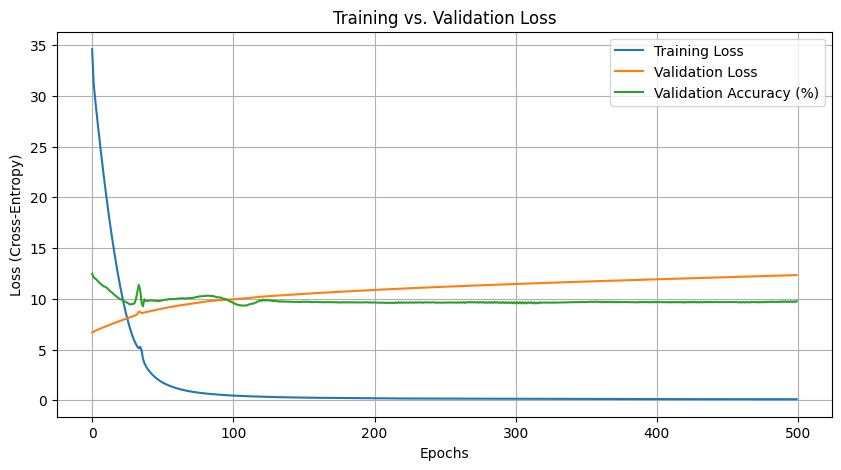

In [138]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_per_epoch, label='Training Loss')
plt.plot(val_loss_per_epoch, label='Validation Loss')
plt.plot(val_acc_per_epoch,label='Validation Accuracy (%)')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.show()

#### Final Validation Loss, Accuracy

Using the elbow method, epoch = 100

In [ ]:
print("Validation Loss",val_loss_per_epoch[99])
print("Validation Accuracy",val_acc_per_epoch[99], "%")

Validation Loss 9.942483901977539
Validation Accuracy 9.668546915054321 %


#### Example predictions and commentary on learning behavior.

### 1.3 Embedding Visualization and Interpretation [1 mark]


#### Random embeddings at model initialization

In [132]:
new_model = MLPTextGenerator(ctx_window, vocab_size, embedding_dim, hidden_dim).to(device)

C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_27628\111011432.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


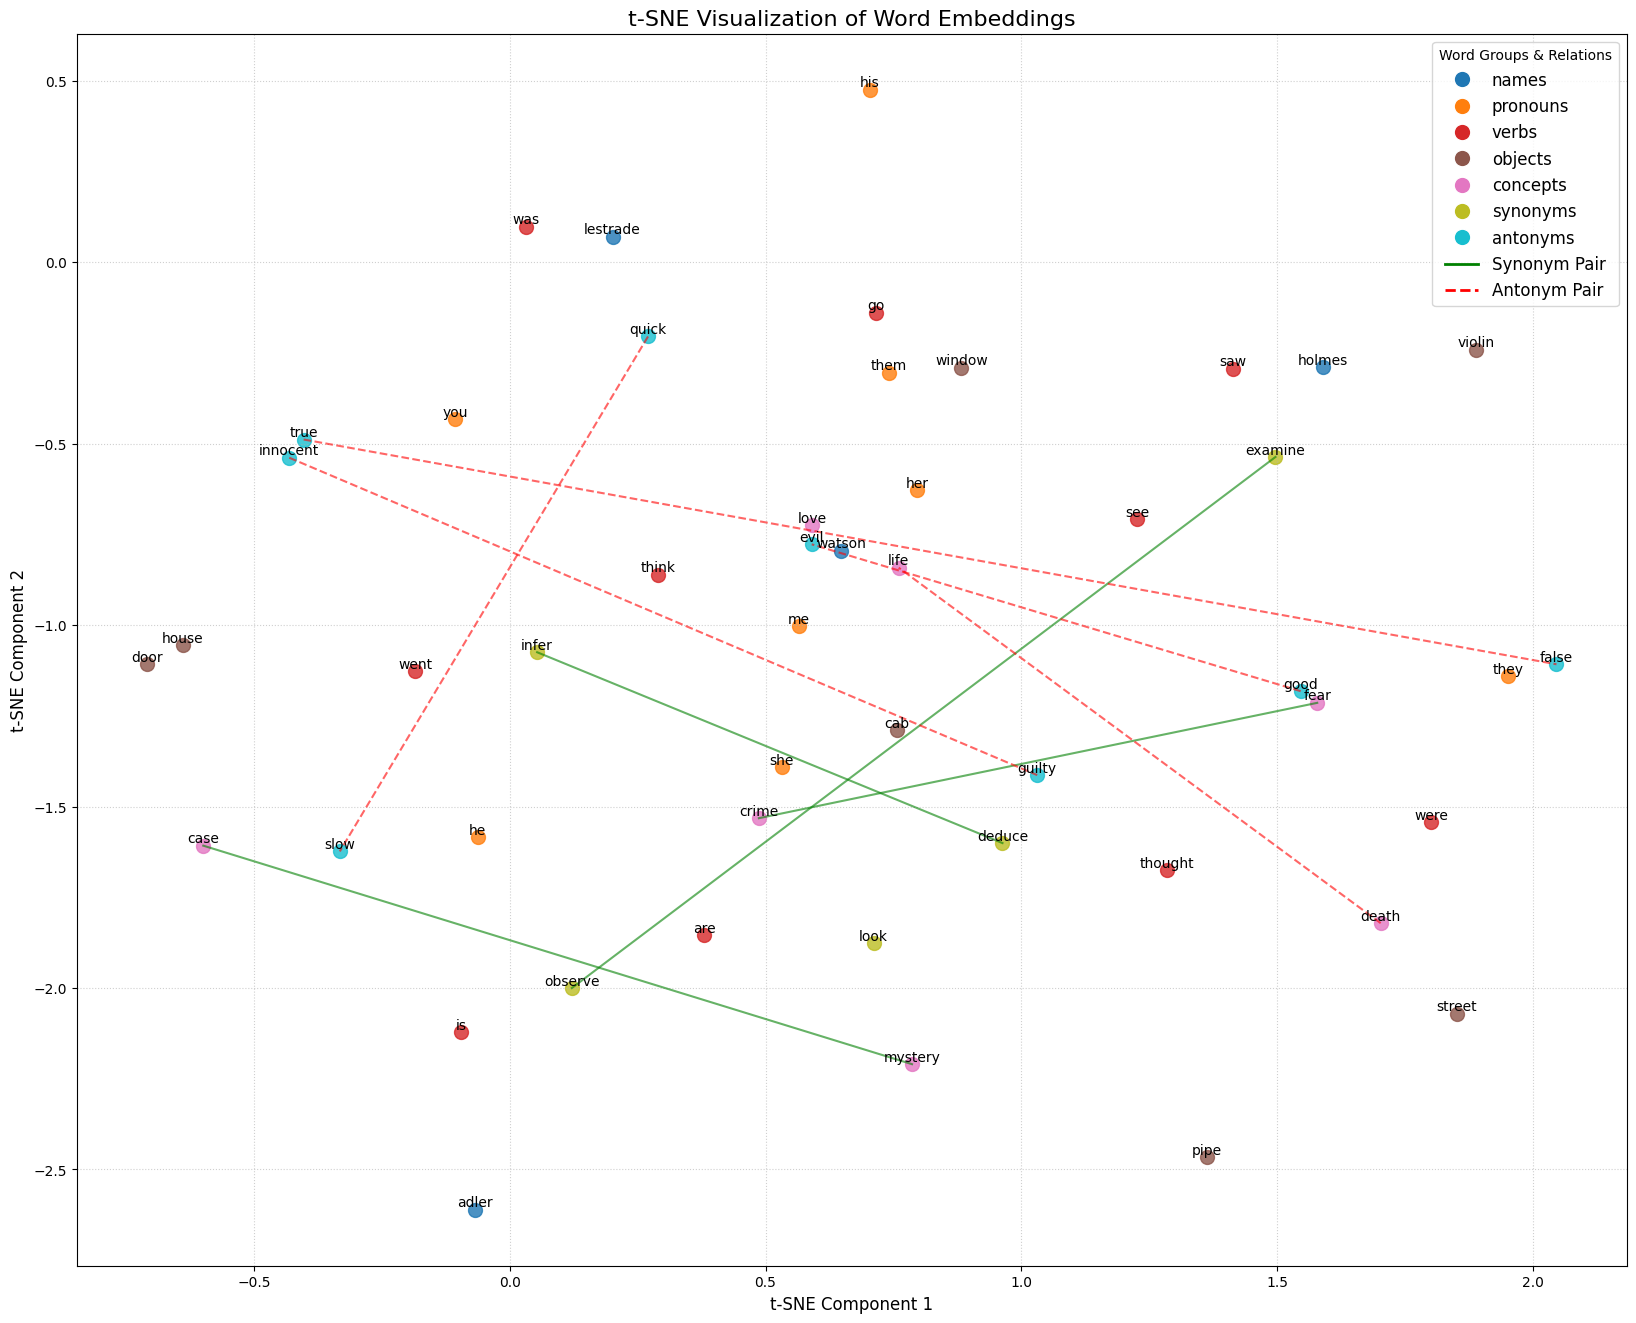

In [133]:
visualize_embeddings(new_model,stoi)

#### Learned Embeddigngs

C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_27628\111011432.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


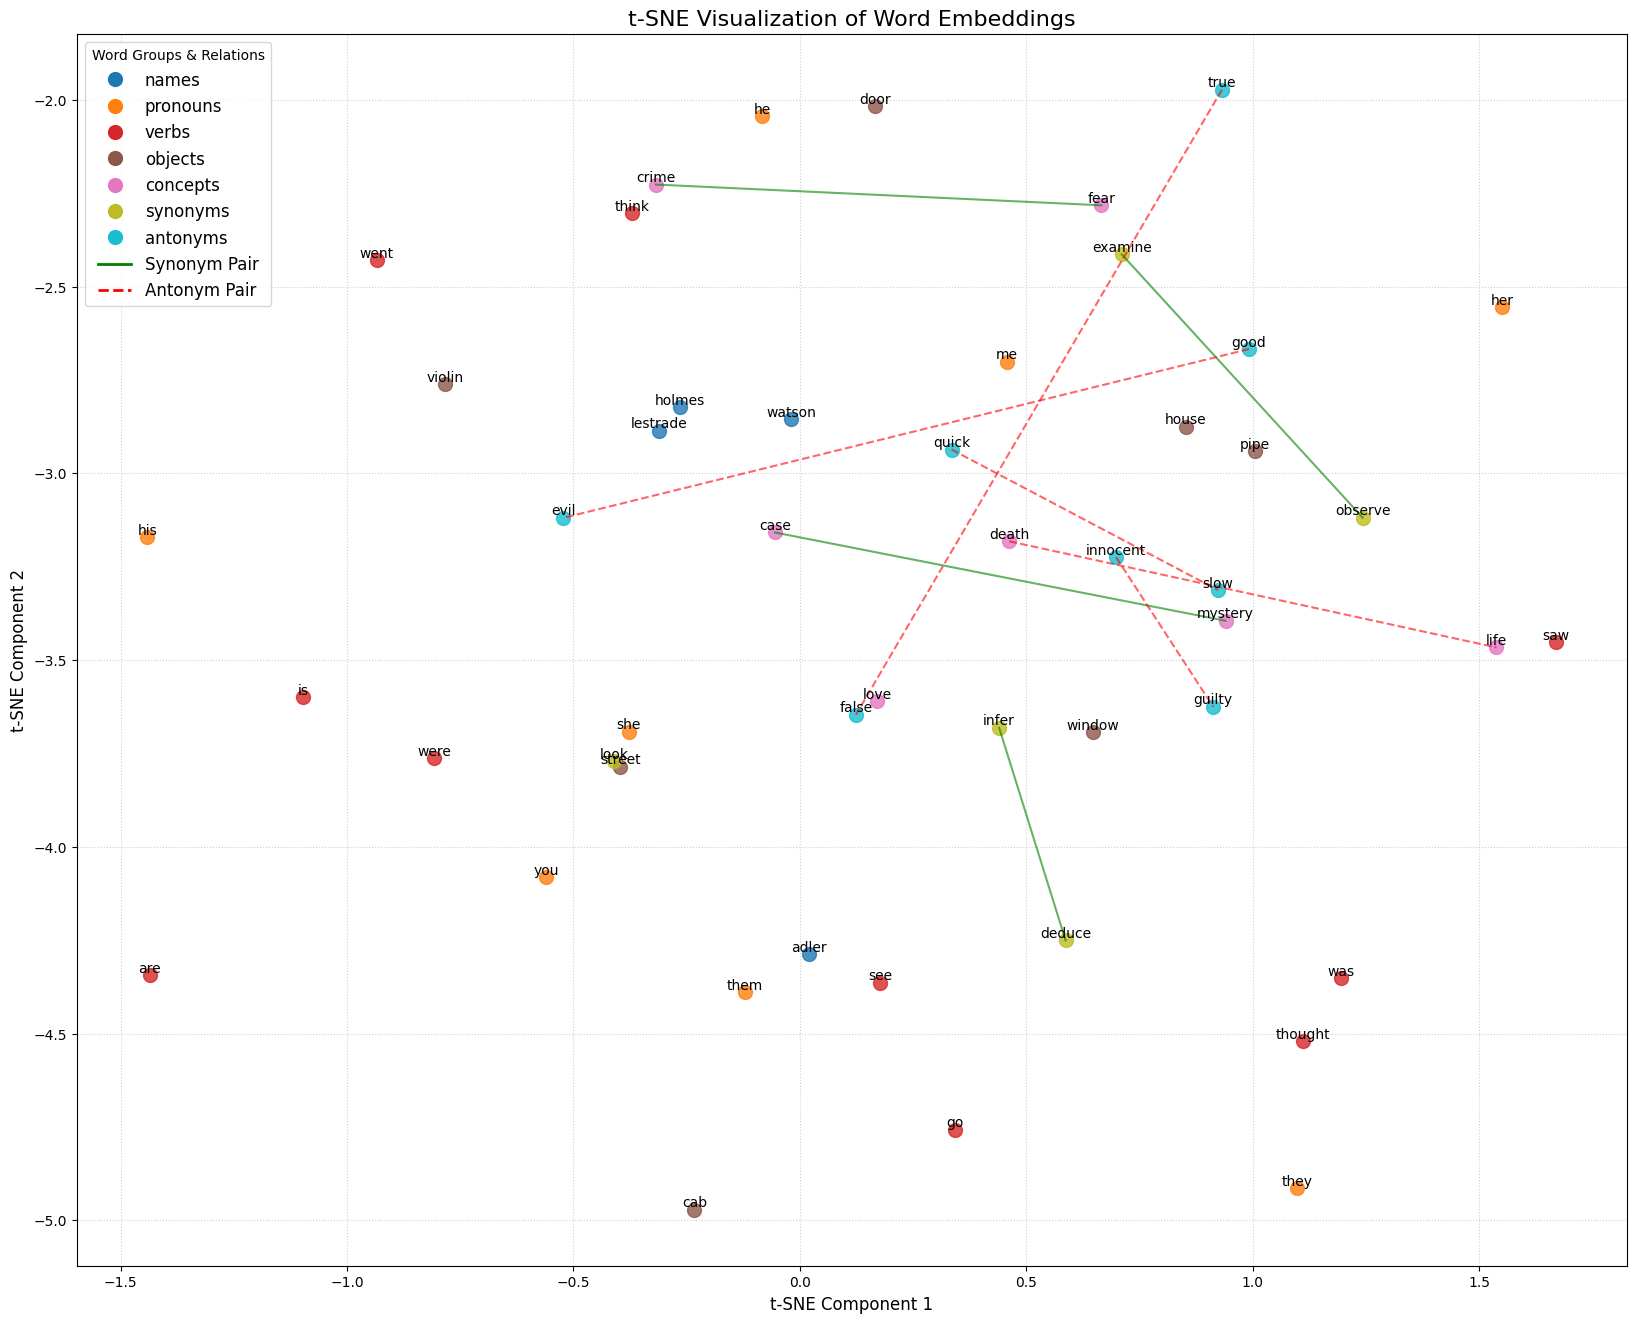

In [134]:
visualize_embeddings(model,stoi)

### 1.4 Streamlit Application [1.5 marks]
See [`./q1_streamlit.py`](./q1_streamlit.py)

#### Models: Category 1

In [ ]:
_epochs = 120
embeddimg_dims = [32,64]
context_size = [4,8,12]
activations = [nn.ReLU(),nn.Tanh()]

class MLPTextGenerator_(nn.Module):
    def __init__(self, ctx_window, vocab_size, embedding_dim, hidden_dim,activation):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # embedding layer
        self.fc1 = nn.Linear(embedding_dim * ctx_window, hidden_dim)  # first hidden layer
        self.act = activation  # activation function
        self.fc2 = nn.Linear(hidden_dim, vocab_size)  # output layer

    def forward(self, x):
        embeds = self.embedding(x)
        embeds = embeds.view(x.shape[0], -1)  # flatten embeddings
        out = self.fc1(embeds)  # fully connected layer
        out = self.act(out)  # relu activation
        out = self.fc2(out)  # output
        return out

for embedding_dim, ctx_sz,activation in itertools.product(embeddimg_dims,context_size,activations):
    X,Y,stoi,itos,_,_ = make_dataset(file_path,ctx_sz)
    vocab_size = len(stoi)
    X_train, X_val, Y_train, Y_val = train_test_split(
        X.cpu(), Y.cpu(), test_size=test_size, random_state=42
    )
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
    X_val, Y_val = X_val.to(device), Y_val.to(device)
    
    model_ = MLPTextGenerator_(ctx_sz,len(stoi),embedding_dim,768,activation)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model_.parameters(), lr=0.001)
    model_.to(device)
    train_loss_epch = []
    val_loss_epch = []
    val_acc_epch = []
    best_val_loss = float('inf')
    best_model_state = None
    for epoch in tqdm(range(_epochs), desc="Epochs", position=0):
        model_.train()
        epoch_train_loss = 0.0
        for i in tqdm(range(0, X_train.shape[0], batch_size), 
                    desc=f"Training Epoch {epoch}", 
                    leave=False, 
                    position=1):

            x = X_train[i:i+batch_size]
            y = Y_train[i:i+batch_size]

            y_pred = model_(x)
            loss = loss_fn(y_pred, y)

            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_train_loss += loss.item()
        train_loss_epch.append(epoch_train_loss)
        
        # Validation
        model_.eval()
        with torch.no_grad():
            outputs = model_(X_val)
            val_loss = loss_fn(outputs, Y_val).item()
            _, predicted = torch.max(outputs, 1)
            val_acc = (predicted == Y_val).float().mean().item() * 100
        if (epoch+1) % 60 == 0:
            tqdm.write(
                f"Epoch {epoch:03d} | "
                f"Train Loss: {epoch_train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | "
                f"Val Acc: {val_acc:.2f}%"
            )
        val_loss_epch.append(val_loss)
        val_acc_epch.append(val_acc)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model_.state_dict()
    with open(f'./saved_models_q1/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_arrays.json','w') as f:
        f.write(json.dumps({'train_loss':train_loss_epch,'val_loss':val_loss_epch,'val_acc':val_acc_epch},indent=4))
        
    best_model_path = f'./saved_models_q1/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_best.pth'
    torch.save(best_model_state, best_model_path)

    final_model_path = f'./saved_models_q1/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_final.pth'
    torch.save(model_.state_dict(), final_model_path)   

Epochs:  50%|█████     | 60/120 [00:36<00:36,  1.66it/s]

Epoch 059 | Train Loss: 22.5888 | Val Loss: 9.8432 | Val Acc: 11.78%


Epochs: 100%|██████████| 120/120 [01:12<00:00,  1.66it/s]


Epoch 119 | Train Loss: 9.3761 | Val Loss: 12.7071 | Val Acc: 10.57%


Epochs:  50%|█████     | 60/120 [00:36<00:36,  1.62it/s]

Epoch 059 | Train Loss: 32.1434 | Val Loss: 7.0605 | Val Acc: 12.34%


Epochs: 100%|██████████| 120/120 [01:12<00:00,  1.64it/s]


Epoch 119 | Train Loss: 9.4019 | Val Loss: 8.5872 | Val Acc: 10.66%


Epochs:  50%|█████     | 60/120 [00:36<00:36,  1.63it/s]

Epoch 059 | Train Loss: 9.2780 | Val Loss: 11.0682 | Val Acc: 8.90%


Epochs: 100%|██████████| 120/120 [01:13<00:00,  1.63it/s]


Epoch 119 | Train Loss: 2.4045 | Val Loss: 14.6465 | Val Acc: 9.16%


Epochs:  50%|█████     | 60/120 [00:37<00:37,  1.62it/s]

Epoch 059 | Train Loss: 15.4426 | Val Loss: 7.7179 | Val Acc: 9.47%


Epochs: 100%|██████████| 120/120 [01:14<00:00,  1.61it/s]


Epoch 119 | Train Loss: 1.4525 | Val Loss: 9.5264 | Val Acc: 8.97%


Epochs:  50%|█████     | 60/120 [00:38<00:37,  1.58it/s]

Epoch 059 | Train Loss: 3.5030 | Val Loss: 11.9092 | Val Acc: 8.03%


Epochs: 100%|██████████| 120/120 [01:13<00:00,  1.63it/s]


Epoch 119 | Train Loss: 0.2834 | Val Loss: 14.2052 | Val Acc: 8.22%


Epochs:  50%|█████     | 60/120 [00:34<00:34,  1.72it/s]

Epoch 059 | Train Loss: 6.6477 | Val Loss: 8.1781 | Val Acc: 9.60%


Epochs: 100%|██████████| 120/120 [01:08<00:00,  1.74it/s]


Epoch 119 | Train Loss: 0.6286 | Val Loss: 9.4955 | Val Acc: 8.10%


Epochs:  50%|█████     | 60/120 [00:33<00:33,  1.77it/s]

Epoch 059 | Train Loss: 11.1636 | Val Loss: 10.3526 | Val Acc: 11.25%


Epochs: 100%|██████████| 120/120 [01:07<00:00,  1.77it/s]


Epoch 119 | Train Loss: 3.9682 | Val Loss: 13.0126 | Val Acc: 10.25%


Epochs:  50%|█████     | 60/120 [00:34<00:34,  1.72it/s]

Epoch 059 | Train Loss: 15.4467 | Val Loss: 7.3969 | Val Acc: 11.73%


Epochs: 100%|██████████| 120/120 [01:09<00:00,  1.73it/s]


Epoch 119 | Train Loss: 3.1474 | Val Loss: 8.9745 | Val Acc: 10.99%


Epochs:  50%|█████     | 60/120 [00:35<00:36,  1.66it/s]

Epoch 059 | Train Loss: 2.1646 | Val Loss: 11.6399 | Val Acc: 10.59%


Epochs: 100%|██████████| 120/120 [01:11<00:00,  1.68it/s]


Epoch 119 | Train Loss: 0.1833 | Val Loss: 13.2308 | Val Acc: 9.79%


Epochs:  50%|█████     | 60/120 [00:35<00:35,  1.68it/s]

Epoch 059 | Train Loss: 2.6511 | Val Loss: 8.0423 | Val Acc: 9.95%


Epochs: 100%|██████████| 120/120 [01:11<00:00,  1.68it/s]


Epoch 119 | Train Loss: 0.3361 | Val Loss: 8.9974 | Val Acc: 9.53%


Epochs:  50%|█████     | 60/120 [00:36<00:36,  1.63it/s]

Epoch 059 | Train Loss: 0.4744 | Val Loss: 11.3406 | Val Acc: 8.93%


Epochs: 100%|██████████| 120/120 [01:13<00:00,  1.63it/s]


Epoch 119 | Train Loss: 0.0969 | Val Loss: 12.6474 | Val Acc: 8.57%


Epochs:  50%|█████     | 60/120 [00:36<00:36,  1.62it/s]

Epoch 059 | Train Loss: 1.0646 | Val Loss: 8.1439 | Val Acc: 9.97%


Epochs: 100%|██████████| 120/120 [01:13<00:00,  1.64it/s]

Epoch 119 | Train Loss: 0.1920 | Val Loss: 8.8870 | Val Acc: 9.72%


In [ ]:
for embedding_dim, ctx_sz,activation in itertools.product(embeddimg_dims,context_size,activations):
    X,Y,stoi,itos,_,_ = make_dataset(file_path,ctx_sz)
    with open(f'./saved_models_q1/stoi_sherlock.json','w') as f:
        f.write(json.dumps(stoi,indent=4))
    break

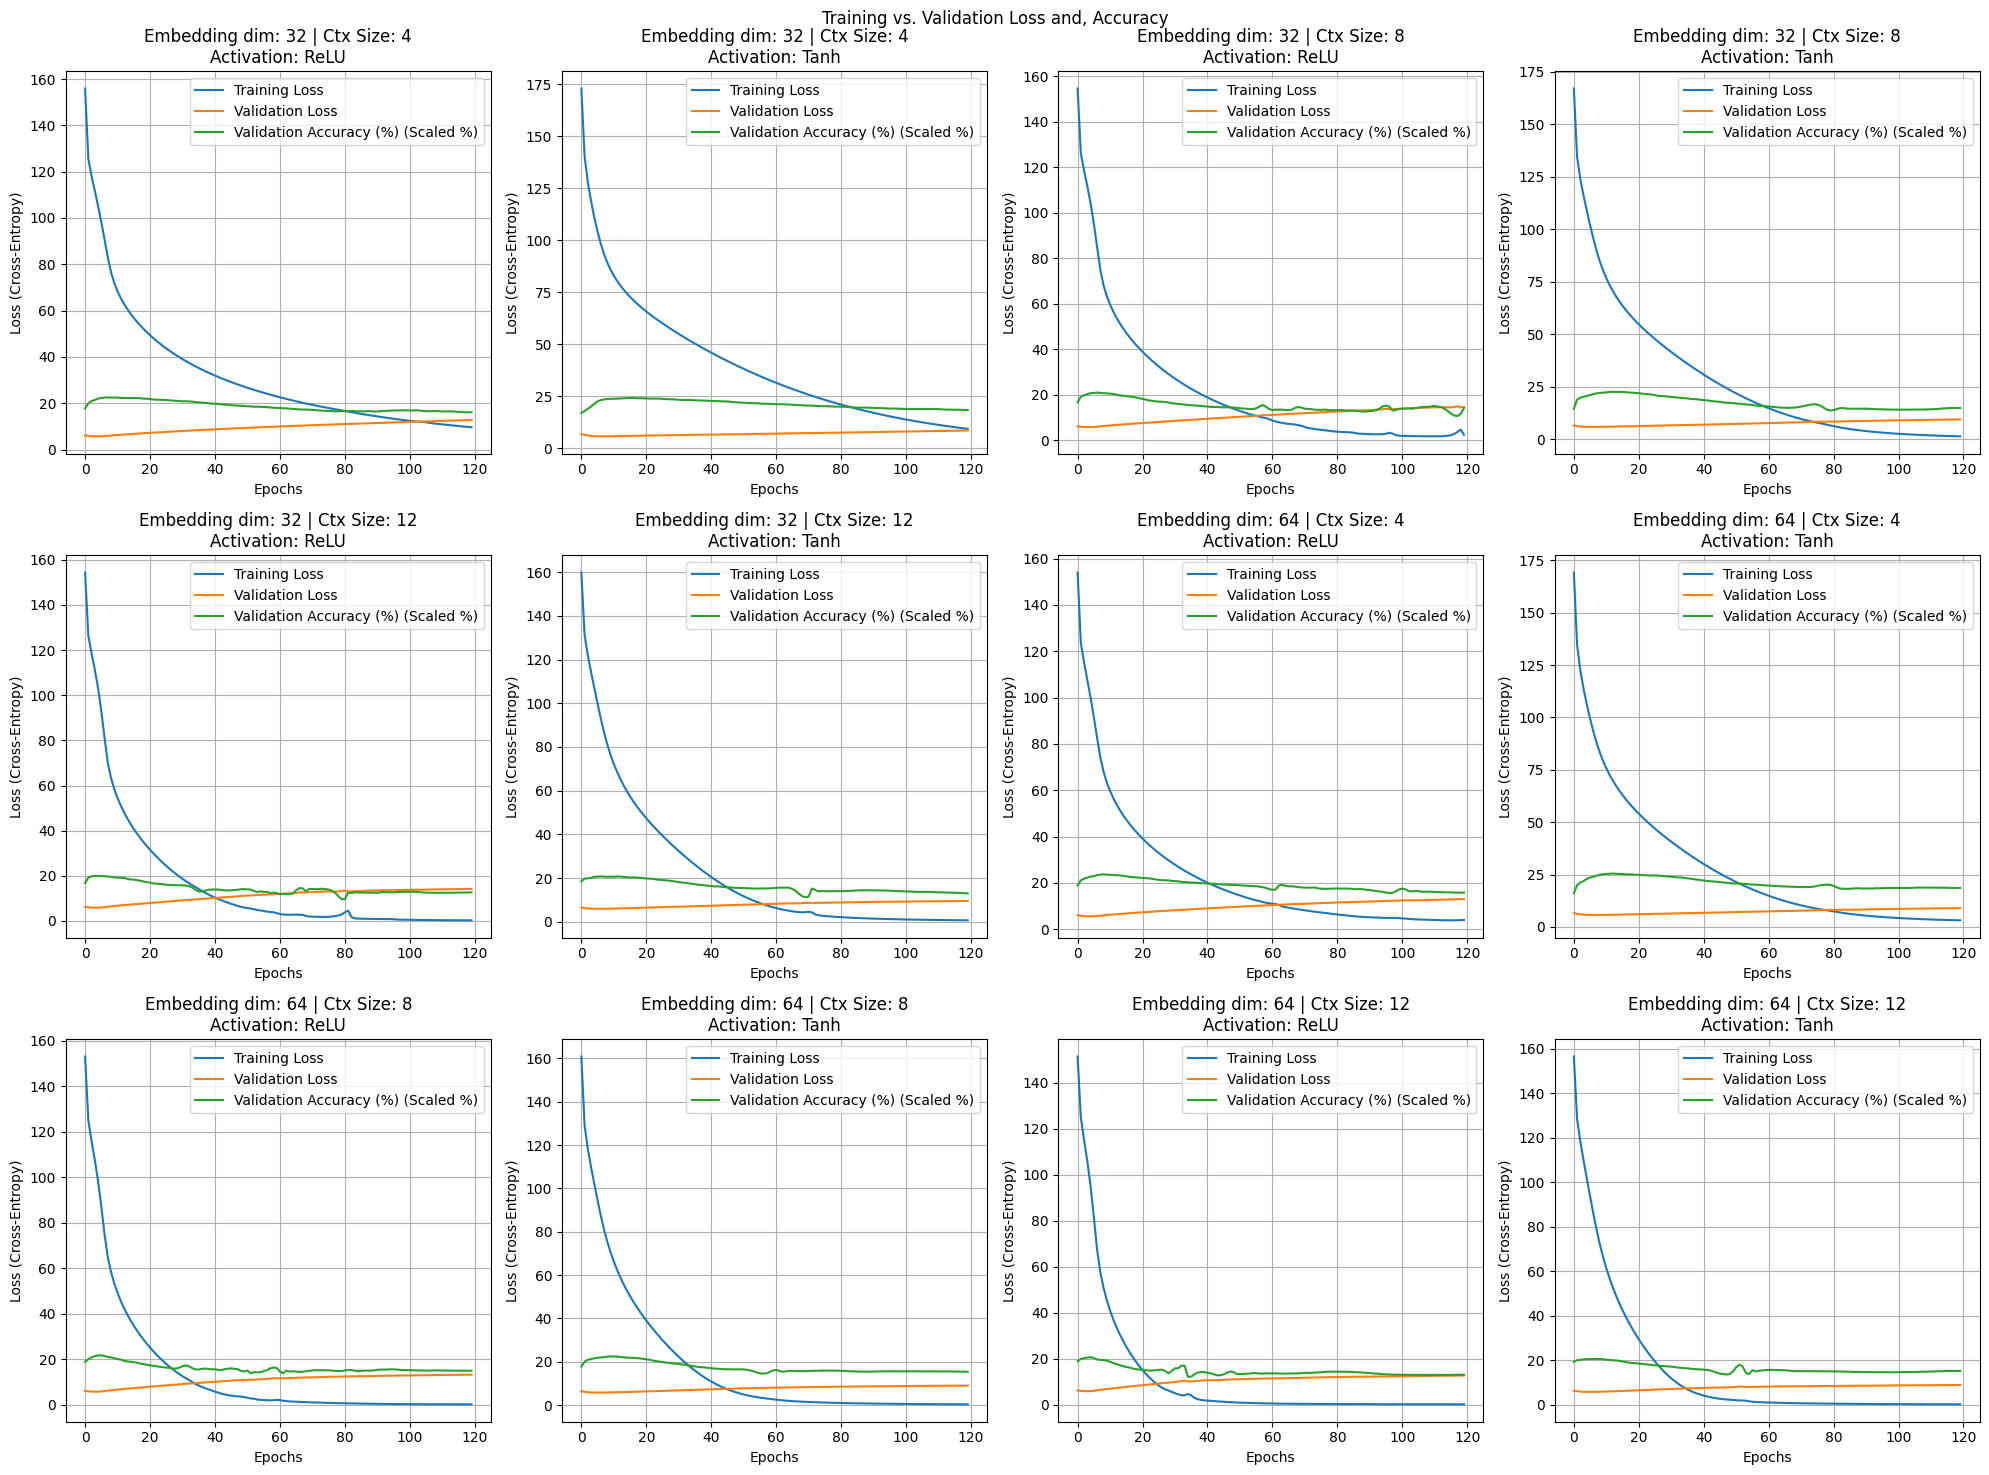

In [42]:
def plot(log = False):
    plt.figure(figsize=(20,15))
    for idx, (embedding_dim, ctx_sz,activation) in enumerate(itertools.product(embeddimg_dims,context_size,activations),1):
        plt.subplot(3,4,idx)
        with open(f'./saved_models_q1/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_arrays.json','r') as f:
            data = json.load(f)
            tr_lss_arr = data['train_loss']
            val_lss_arr = data['val_loss']
            val_acc_arr = data['val_acc']
        plt.plot(tr_lss_arr, label='Training Loss')
        plt.plot(val_lss_arr, label='Validation Loss')
        plt.plot(np.array(val_acc_arr)/100 * max(np.max(tr_lss_arr),np.max(val_lss_arr)),label='Validation Accuracy (%) (Scaled %)')
        plt.title(f'Embedding dim: {embedding_dim} | Ctx Size: {ctx_sz}\nActivation: {activation._get_name()}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Cross-Entropy)')
        if log:
            plt.yscale('log')
        plt.legend()
        plt.grid(True)
    plt.suptitle('Training vs. Validation Loss and, Accuracy')
    plt.tight_layout()
    plt.show()
plot()

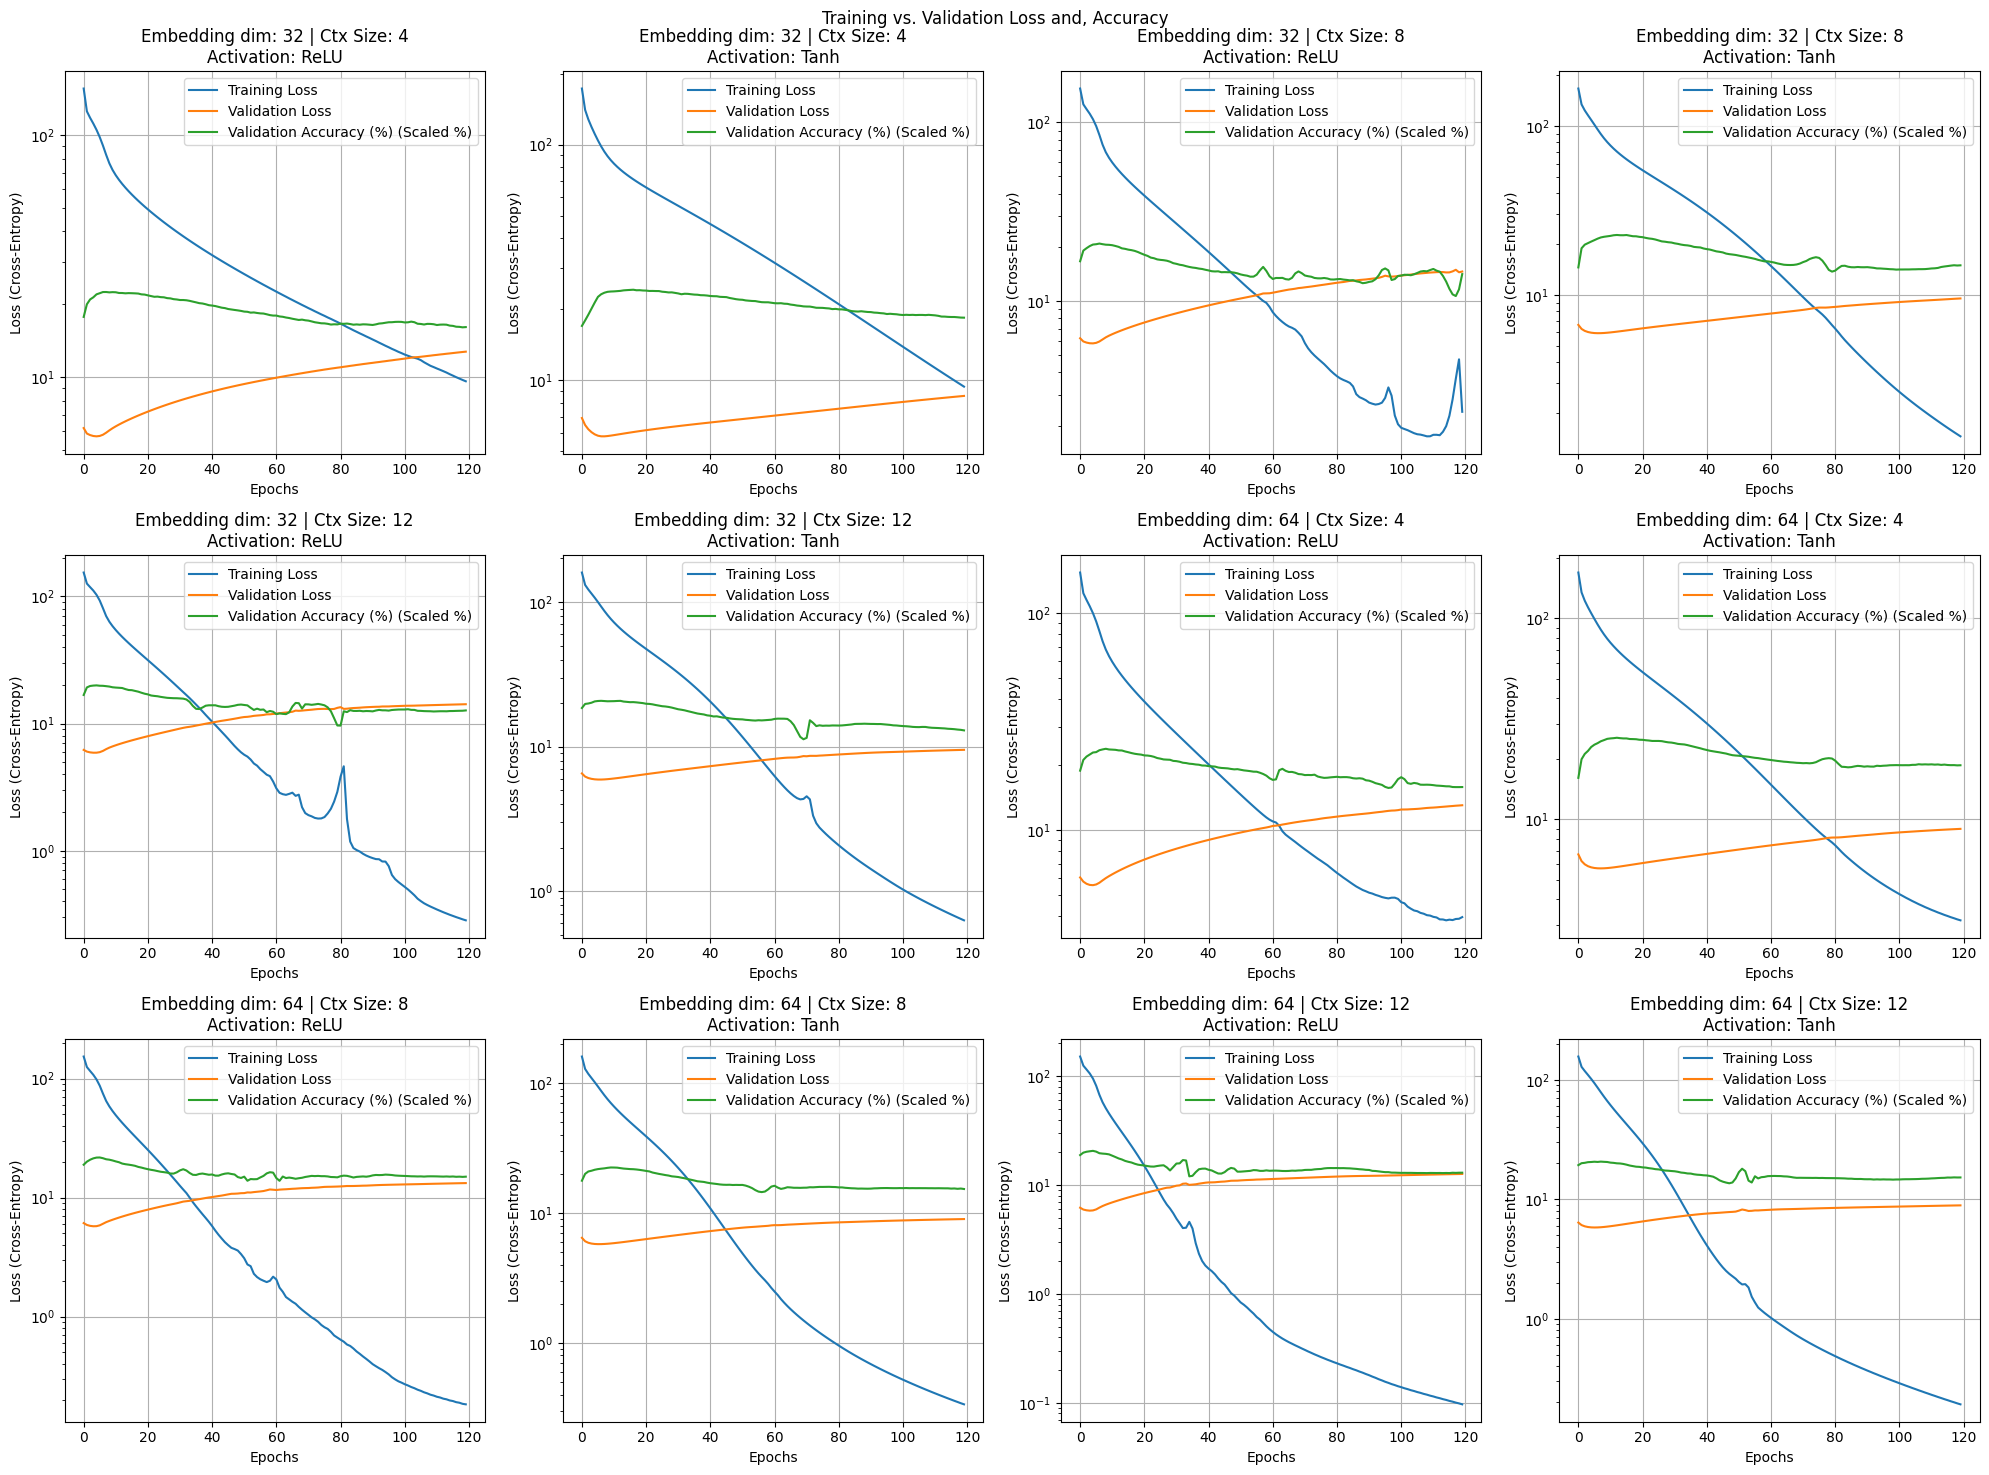

In [43]:
plot(True)

#### Best Model Category 1

In [23]:
best_model_path

'./saved_models_q1/e32_c4_aReLU_best.pth'

C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_480\1390907882.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


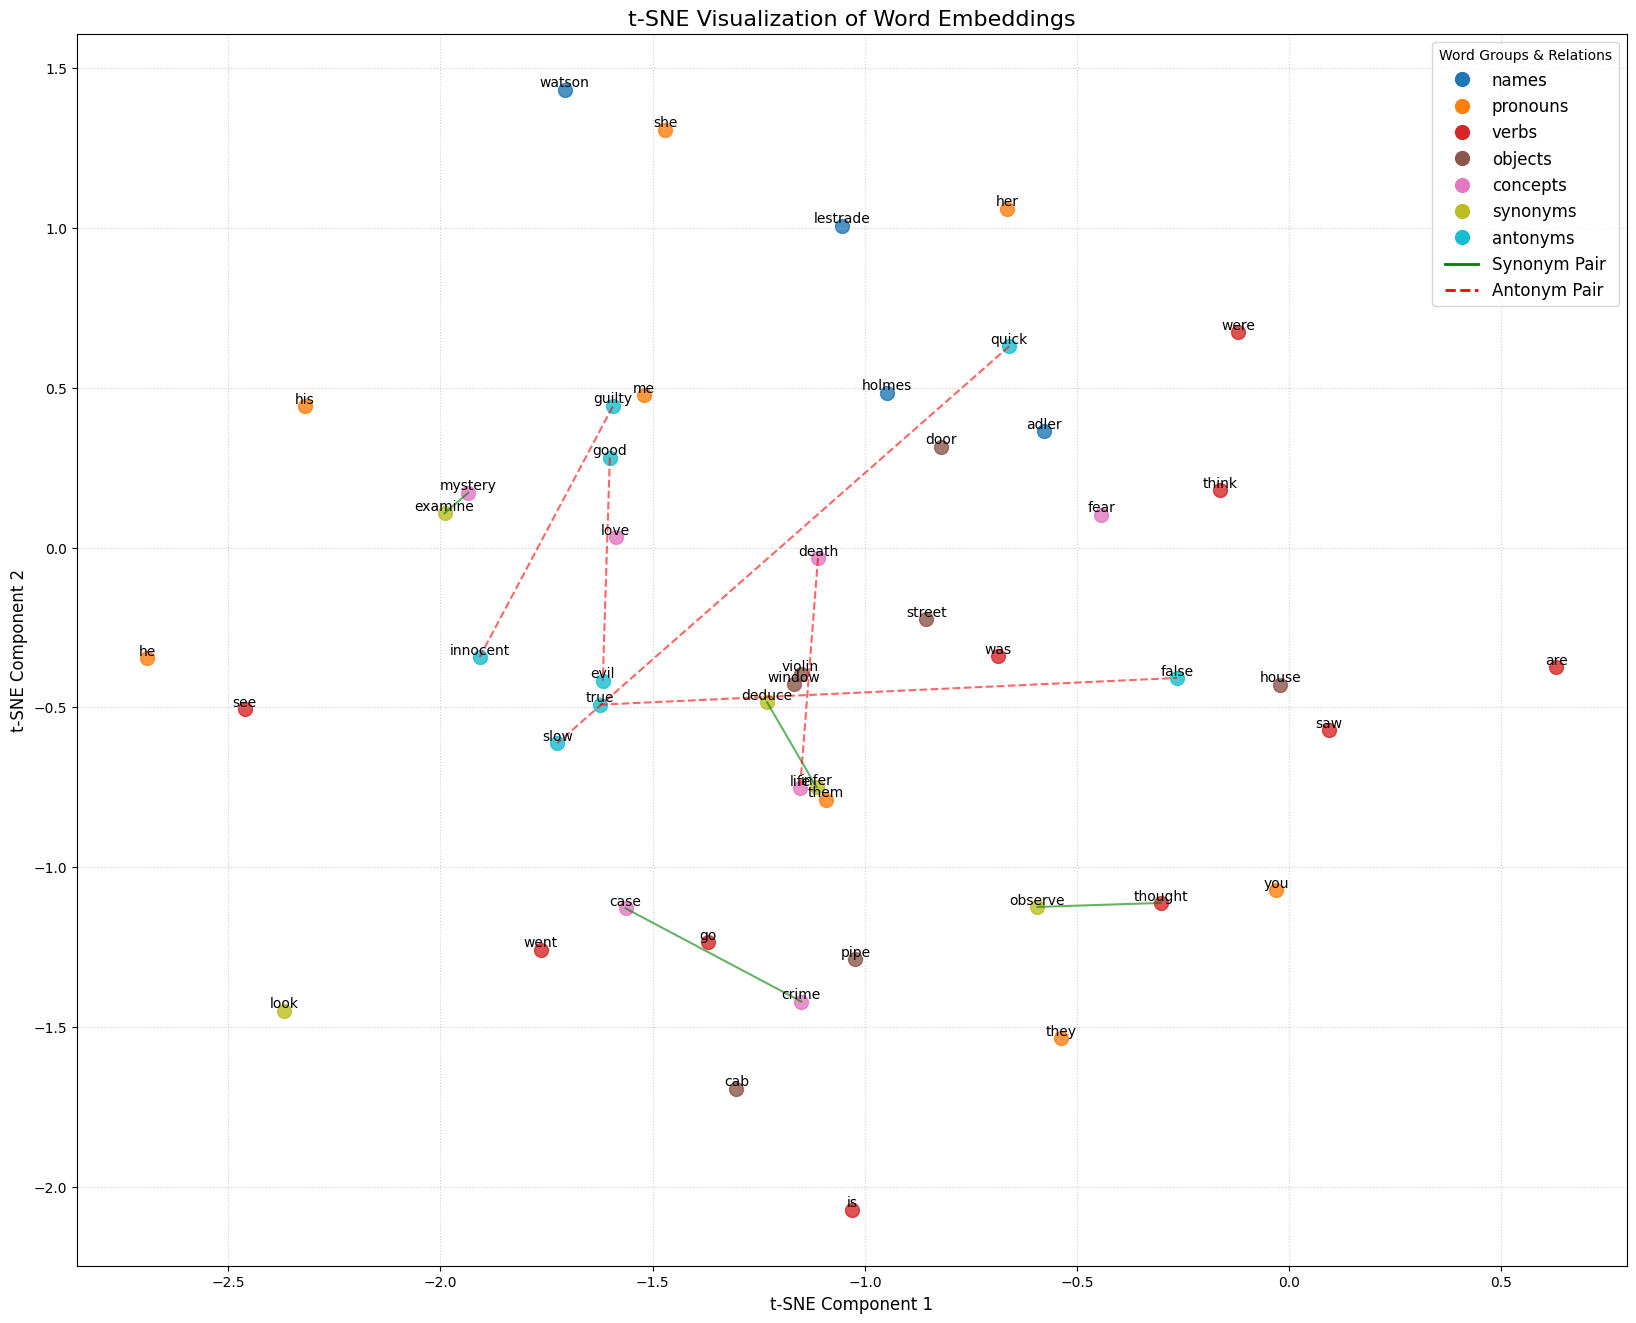

In [29]:
loaded_model = MLPTextGenerator_(
    ctx_window=4, 
    vocab_size=vocab_size, 
    embedding_dim=32, 
    hidden_dim=768, 
    activation=nn.ReLU()
).to(device)

loaded_model.load_state_dict(best_model_state)
loaded_model.eval()

visualize_embeddings(loaded_model,stoi)

## Category 2: Linux Kernel Code                

### 1.1 Preprocessing and Vocabulary Construction [0.5 mark]

In [4]:
def tokenize_c_code(filepath):
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        code = f.read()
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    code = re.sub(r'//.*', '', code)

    token_patterns = [
        ('INCL', r'#include'), 
        ('HEAD',   r'<[^>]+>'), #headers
        ('PREP', r'#\s*(define|ifdef|ifndef|endif)'), # preprocessor
        ('KWRD', r'\b(auto|break|case|char|const|continue|default|do|double|else|enum|extern|'
                r'float|for|goto|if|inline|int|long|register|restrict|return|short|signed|sizeof|'
                r'static|struct|switch|typedef|union|unsigned|void|volatile|while)\b'), # keywords
        ('IDFR', r'\b[A-Za-z_][A-Za-z0-9_]*\b'), # identifiers
        ('NMBR', r'\b\d+(\.\d+)?\b'), # numbers
        ('STRN', r'\"(?:\\.|[^\"\\\\])*\"'), # strings
        ('OPRT', r'==|!=|<=|>=|->|&&|\|\||\+\+|--|[+\-*/%=&|<>!~^]'), # trivial operators
        ('DLMT', r'[;:,.\\[\\]\\(\\)\\{\\}]'), # delimiters
        ('NEWL', r'\n'), # new line
        ('WHSP', r'[ \t]+'), # whitespaces
        ('MTAN', r'.'), # anything else. (match anytbning)
    ]
    master_pattern = re.compile('|'.join(f'(?P<{name}>{pattern})' for name, pattern in token_patterns))
    
    tokens = []
    for match in master_pattern.finditer(code):
        token_type = match.lastgroup
        token_value = match.group()
        if token_type == 'NEWL':
            tokens.append('\\n')
        elif token_type == 'WHSP':
            tokens.append('\\s')
        elif token_type != 'MTAN':
            tokens.append(token_value)
    return tokens

file_path = 'question1_datasets/linux_kernel_code.txt'
all_tokens = tokenize_c_code(file_path)

vocab = sorted(list(set(all_tokens)))
stoi = {s: i + 1 for i, s in enumerate(vocab)}
stoi['<UNKN>'] = 0 # unkown token
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

word_counts = Counter(all_tokens)
most_common = word_counts.most_common(10)
least_common = word_counts.most_common()[:-11:-1]

print(f"Vocabulary Size: {vocab_size}")
print("\n10 Most Frequent Tokens:")
for token, count in most_common:
    print(f"{repr(token)}: {count}")

print("\n10 Least Frequent Tokens:")
for token, count in least_common:
    print(f"{repr(token)}: {count}")

def make_dataset(ctx_sz, stoi):
    X, Y = [], []
    for i in range(len(all_tokens) - ctx_sz):
        context = all_tokens[i : i + ctx_sz]
        target = all_tokens[i + ctx_sz]
        X.append([stoi.get(t, stoi['<UNKN>']) for t in context])
        Y.append(stoi.get(target, stoi['<UNKN>']))

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

Vocabulary Size: 28791

10 Most Frequent Tokens:
'\\s': 284792
'\\n': 150800
'->': 24312
'=': 22108
'*': 17461
'struct': 13414
'if': 11456
'&': 11028
'return': 7888
'int': 7476

10 Least Frequent Tokens:
'context_tracking_init': 1
'CONFIG_CONTEXT_TRACKING_FORCE': 1
'__context_tracking_task_switch': 1
'CONTEXT_KERNEL': 1
'trace_user_exit': 1
'vtime_user_exit': 1
'trace_user_enter': 1
'<trace/events/context_tracking.h>': 1
'kstat_irqs_usr': 1
'kstat_incr_irq_this_cpu': 1


In [ ]:
def visualize_code_embeddings(model, stoi):
    code_groups = {
        'types': ['int', 'char', 'void', 'struct', 'long', 'unsigned'],
        'control': ['if', 'else', 'for', 'while', 'return', 'break', 'switch'],
        'operators': ['+', '-', '*', '/', '=', '->', '&', '|', '=='],
        'delimiters': ['(', ')', '{', '}', '[', ']', ';', ','],
        'preprocessor': ['#include', '#define', '#ifdef', '#endif']
    }
    
    words_to_plot = []
    group_labels = []
    for group, words in code_groups.items():
        for word in words:
            if word in stoi and word not in words_to_plot:
                words_to_plot.append(word)
                group_labels.append(group)
    
    embeddings = model.embedding.weight.data.cpu().numpy()
    word_indices = [stoi[word] for word in words_to_plot]
    selected_embeddings = embeddings[word_indices]
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(word_indices)-1))
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    plt.figure(figsize=(16, 12))
    unique_groups = list(code_groups.keys())
    colors = plt.cm.get_cmap('tab10', len(unique_groups))
    group_to_color = {group: colors(i) for i, group in enumerate(unique_groups)}
    
    for i, word in enumerate(words_to_plot):
        x, y = embeddings_2d[i]
        group = group_labels[i]
        plt.scatter(x, y, color=group_to_color[group], s=100)
        plt.annotate(repr(word).strip("'"), (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=group,
                                  markerfacecolor=group_to_color[group], markersize=10)
                       for group in unique_groups]
    plt.legend(handles=legend_elements, title="Token Groups")
    plt.title('t-SNE Visualization of C Code Token Embeddings')
    plt.show()

### 1.2 Model Design and Training [1 marks]

In [5]:
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, context_window, activation_fn):
        super(MLPTextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_window * embedding_dim, hidden_dim)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x).view(x.shape[0], -1)
        out = self.activation(self.fc1(embedded))
        return self.fc2(out)

def train(model, optimizer, criterion, epochs,ctx_sz,stoi,activation,save=True):
    X,Y = make_dataset(ctx_sz,stoi)
    dataset = TensorDataset(X, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)
    train_losses, val_losses = [], []
    val_accuracy = []
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for xb, yb in tqdm(
            train_loader,
            desc=f"Train [{epoch+1}/{epochs}] {train_losses[-1] if len(train_losses) > 0 else ''}",
            position=0,
            leave=False
        ):
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in tqdm(
                val_loader,
                desc=f"Val [{epoch+1}/{epochs}] {val_losses[-1] if len(val_losses) > 0 else ''}",
                position=0,
                leave=False
            ):
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += yb.size(0)
                correct += (predicted == yb).sum().item()
        
        val_losses.append(epoch_val_loss)
        accuracy = 100 * correct / total
        val_accuracy.append(accuracy)
        if (epoch+1) % 20 == 0:
            tqdm.write(
                f"Epoch {epoch:03d} | "
                f"Train Loss: {epoch_train_loss:.4f} | "
                f"Val Loss: {epoch_val_loss:.4f} | "
                f"Val Acc: {accuracy:.2f}%"
            )
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
    if save:
        with open(f'./saved_models_q1_2/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_arrays.json','w') as f:
            f.write(json.dumps({'train_loss':train_losses,'val_loss':val_losses,'val_acc':val_accuracy},indent=4))
            
        best_model_path = f'./saved_models_q1_2/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_best.pth'
        torch.save(best_model_state, best_model_path)

        final_model_path = f'./saved_models_q1_2/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_final.pth'
        torch.save(model.state_dict(), final_model_path)

    return train_losses, val_losses, val_accuracy   

In [ ]:
ctx_sz = 8
model = MLPTextGenerator(vocab_size, 32, 768, ctx_sz, nn.ReLU()).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, final_accuracy = train(model, optimizer, criterion, 100,ctx_sz,stoi,nn.ReLU(),save=False)

Epoch 009 | Train Loss: 193.2309 | Val Loss: 127.9869 | Val Acc: 58.03%


Epoch 019 | Train Loss: 136.8540 | Val Loss: 139.0926 | Val Acc: 59.44%


Epoch 029 | Train Loss: 107.5637 | Val Loss: 149.9923 | Val Acc: 59.75%


Epoch 039 | Train Loss: 88.3354 | Val Loss: 162.3637 | Val Acc: 59.98%


Epoch 049 | Train Loss: 74.8986 | Val Loss: 175.1187 | Val Acc: 59.95%


Epoch 059 | Train Loss: 65.1259 | Val Loss: 187.6203 | Val Acc: 59.73%


Epoch 069 | Train Loss: 58.0269 | Val Loss: 200.2163 | Val Acc: 59.68%


Epoch 079 | Train Loss: 52.9425 | Val Loss: 211.8327 | Val Acc: 59.61%


Epoch 089 | Train Loss: 49.2136 | Val Loss: 222.9807 | Val Acc: 59.35%


Epoch 099 | Train Loss: 46.6120 | Val Loss: 232.7388 | Val Acc: 59.16%


In [46]:
with open(f'./saved_models_q1_2/stoi_linux.json','w') as f:
    f.write(json.dumps(stoi,indent=4))

In [10]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

23258967


In [35]:
torch.save(model.state_dict(), f'./saved_models_q1_2/model1.pth')

Loading the saved model

In [6]:
ctx_sz = 8
model = MLPTextGenerator(vocab_size, 32, 768, ctx_sz, nn.ReLU()).to(device)
model.load_state_dict(torch.load('./saved_models_q1_2/model1.pth', map_location='cpu'))
model.to(device)

C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_30724\3476941563.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./saved_models_q1_2/model

MLPTextGenerator(
  (embedding): Embedding(28791, 32)
  (fc1): Linear(in_features=256, out_features=768, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=768, out_features=28791, bias=True)
)

Example Predictions

In [8]:
def tokenize_prompt_string(prompt_code):
    token_specification = [
        ('INCL', r'#include'),
        ('HEAD',   r'<[^>]+>'),
        ('PREP', r'#\s*(define|ifdef|ifndef|endif)'),
        ('KWRD', r'\b(auto|break|case|char|const|continue|default|do|double|else|enum|extern|'
                r'float|for|goto|if|inline|int|long|register|restrict|return|short|signed|sizeof|'
                r'static|struct|switch|typedef|union|unsigned|void|volatile|while)\b'),
        ('IDFR', r'\b[A-Za-z_][A-Za-z0-9_]*\b'),
        ('NMBR', r'\b\d+(\.\d+)?\b'),
        ('STRN', r'\"(?:\\.|[^\"\\\\])*\"'),
        ('OPRT', r'==|!=|<=|>=|->|&&|\|\||\+\+|--|[+\-*/%=&|<>!~^]'),
        ('DLMT', r'[;:,.\\[\\]\\(\\)\\{\\}]'),
        ('NEWL', r'\n'),
        ('WHSP', r'[ \t]+'),
        ('MTAN', r'.'),
    ]
    master_pattern = re.compile('|'.join(f'(?P<{name}>{pattern})' for name, pattern in token_specification))
    tokens = []
    for match in master_pattern.finditer(prompt_code):
        token_type = match.lastgroup
        if token_type == 'NEWL':
            tokens.append('\\n')
        elif token_type == 'WHSP':
            tokens.append('\\s')
        elif token_type != 'MTAN':
            tokens.append(match.group())
    return tokens

def generate_code(model, itos, stoi, context_words, block_size, max_len=20):
    model.eval()
    unk_idx = stoi.get('<UNKN>', 0)
    context = [stoi.get(word, unk_idx) for word in context_words]
    
    if len(context) < block_size:
        context = [unk_idx] * (block_size - len(context)) + context
    generated_code = ''
    with torch.no_grad():
        for _ in range(max_len):
            x = torch.tensor(context[-block_size:]).unsqueeze(0).to(device)
            y_pred = model(x)
            probs = F.softmax(y_pred, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            word = itos.get(ix, '<UNKN>')
            if ix == unk_idx:
                break
            context.append(ix)
            if word == '\\n':
                generated_code += '\n'
            elif word == '\\s':
                generated_code += ' '
            else:
                generated_code += word

    return generated_code


code_contexts = [
    "int *p =",
    "*p = ",
    "if (a == NULL) {",
    "free(",
    "node->next = new_node;",
    "typedef struct {",
    "printf(",
    "for (int i = 0;",
    "fseek(fp, 0, SEEK_END);",
    "pthread_create(&",
    "int main() {"
]

for idx, context_str in enumerate(code_contexts, 1):    
    generated_sequence = generate_code(
        model=model,
        itos=itos,
        stoi=stoi,
        context_words=tokenize_prompt_string(context_str),
        block_size=ctx_sz,
        max_len=50  
    )
    
    print(f"--- Sequence {idx} ---")
    print(f"Context: {context_str}")
    print(f"Generated code sequence:\n{context_str}{generated_sequence}\n")

--- Sequence 1 ---
Context: int *p =
Generated code sequence:
int *p = NULL

 if unlikelyaudit_filter_typestate ||
 if !list_empty&waiter->list
 memsetwaiter MUTEX_DEBUG_FREE sizeof*waiter


void debug_rt_mutex_initstruct rt_mutex *lock const char *

--- Sequence 2 ---
Context: *p = 
Generated code sequence:
*p = NULL
 loff_t l

 mutex_lock&event_mutex

 if !file
 goto out

 
 buf_addr = purgatory_buf
 load_addr = curr_load_addr

 if !value
 

--- Sequence 3 ---
Context: if (a == NULL) {
Generated code sequence:
if (a == NULL) {
 rnp->n_balk_exp_gp_tasks++ i rnp->gp_tasks str &symtab->rcu_node_entry 
 do   = 0
 


static inline struct rt_rq *group_rt_rqstruct sched_rt_entity *rt_se

--- Sequence 4 ---
Context: free(
Generated code sequence:
free(

 preempt_enable
 
 return ret


static void event_enable_unregister_triggerchar *glob
 struct event_trigger_ops *ops
 struct event_trigger_data *data

 if CHECK_FETCH_FUNCSderef arg 


--- Sequence 5 ---
Context: node->next = new_node;
Genera

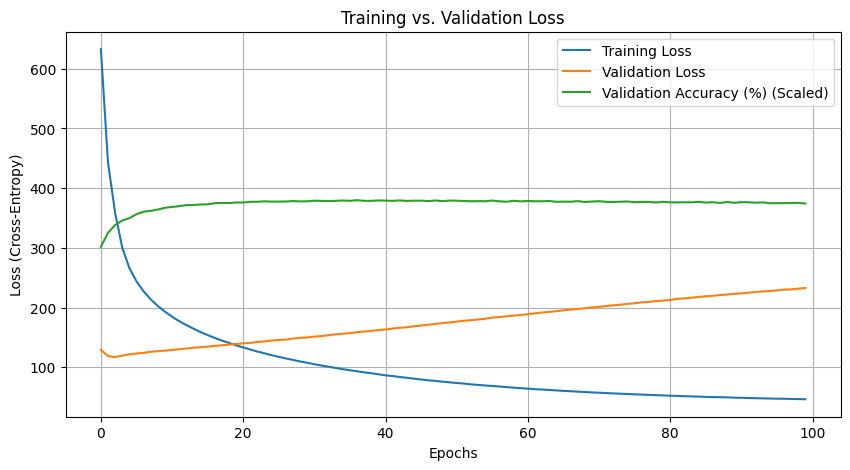

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(np.array(final_accuracy)/100*max(np.max(train_losses),np.max(val_losses)),label='Validation Accuracy (%) (Scaled)')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.show()

### 1.3 Embedding Visualization and Interpretation [1 mark]


#### Random embeddings at model initialization

In [16]:
new_model =  MLPTextGenerator(vocab_size, 32, 768, 8, nn.ReLU()).to(device)

C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_24588\2817235563.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


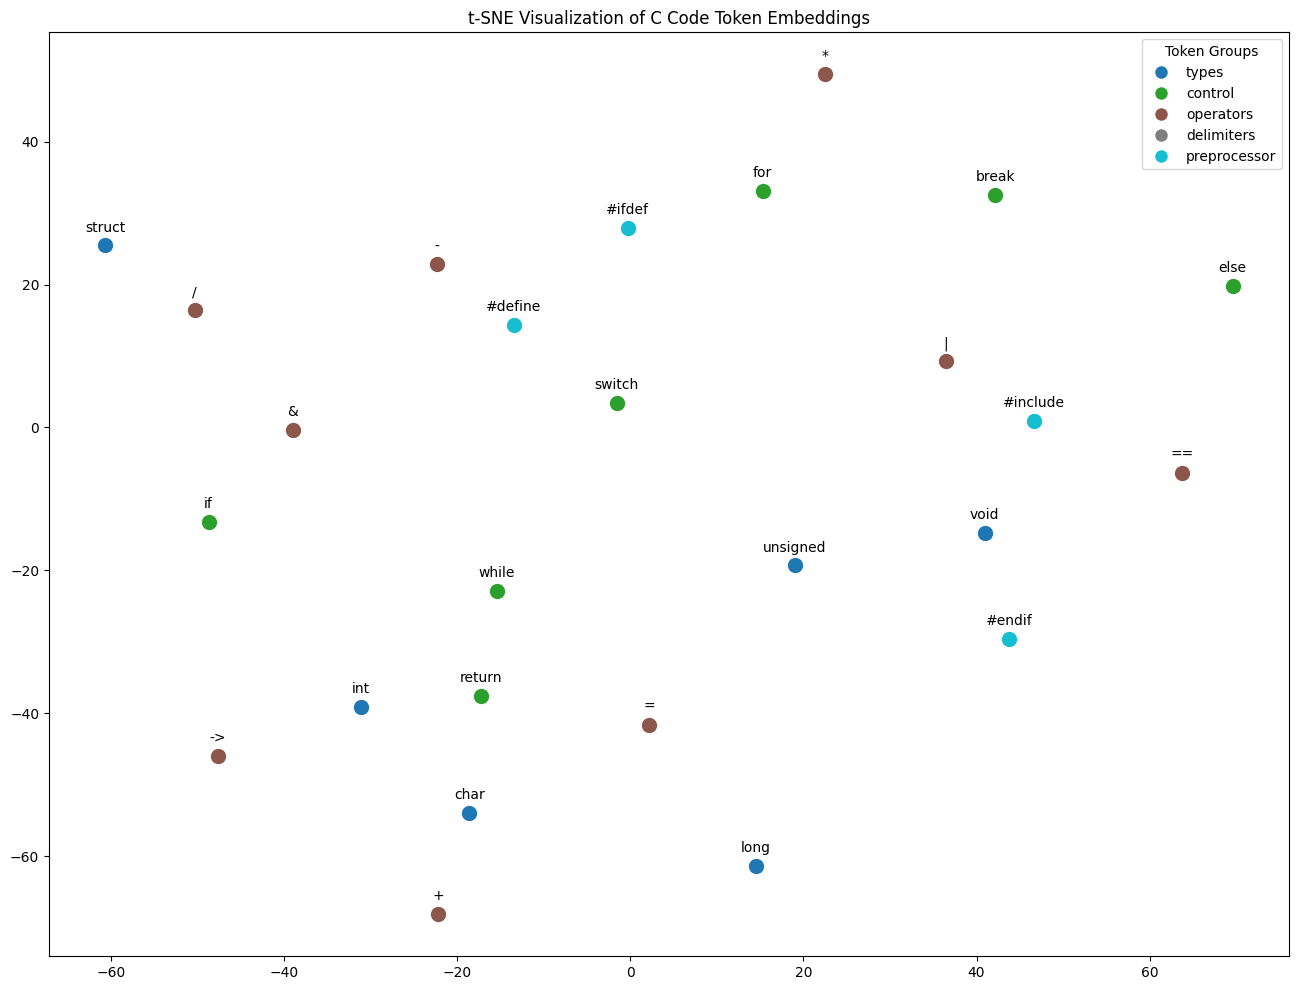

In [17]:
visualize_code_embeddings(new_model, stoi)

#### Learned Embeddings

C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_24588\2817235563.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


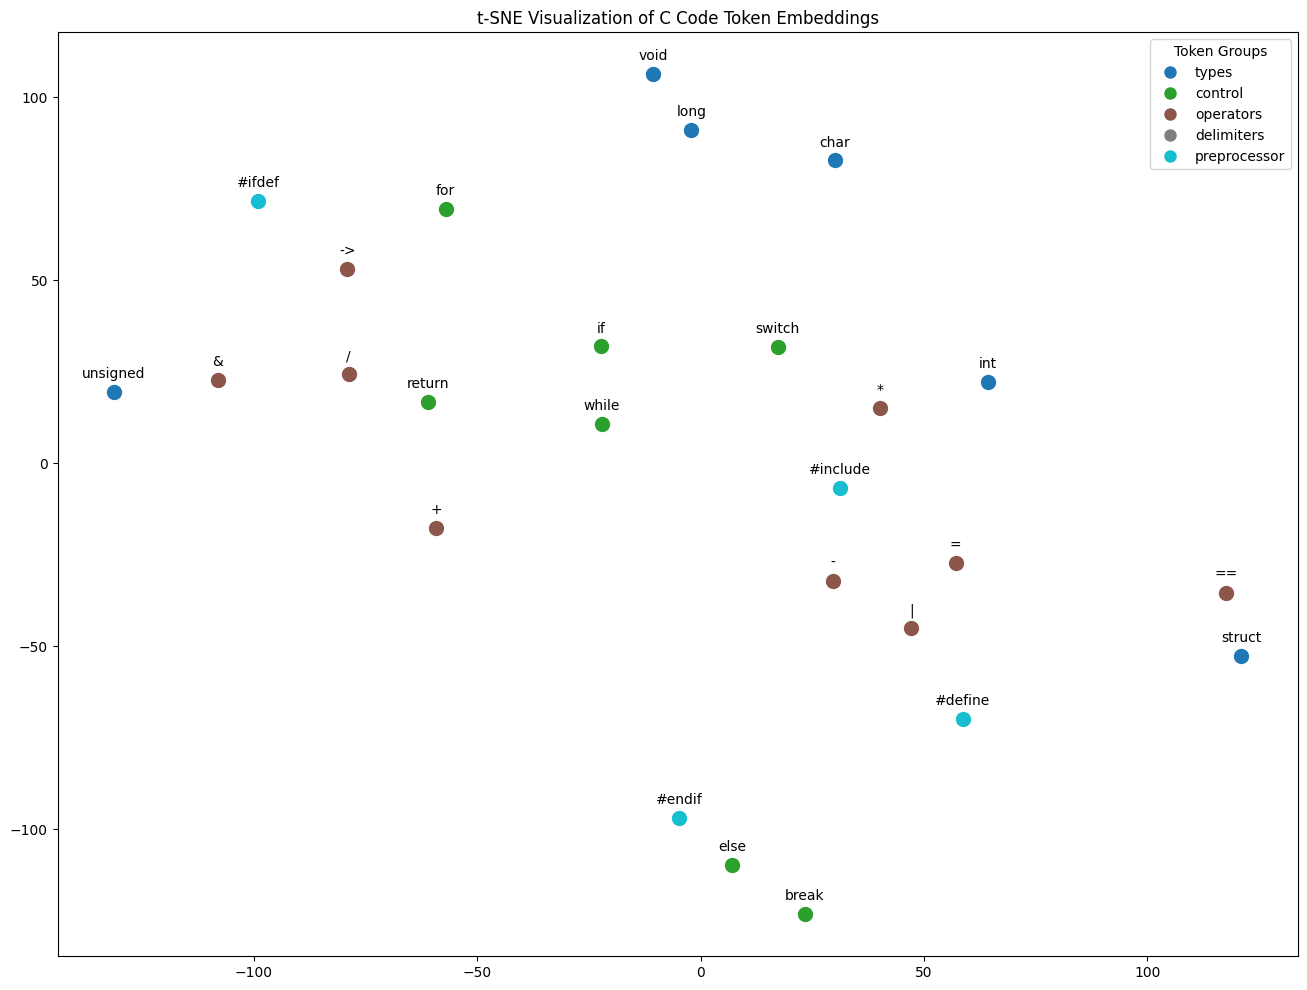

In [19]:
visualize_code_embeddings(model, stoi)

### 1.4 Streamlit Application [1.5 marks]
See [`./q1_streamlit.py`](./q1_streamlit.py)

#### Models: Category 2

In [6]:
_epochs = 100
embeddimg_dims = [32,64]
context_size = [4,8,12]
activations = [nn.ReLU(),nn.Tanh()]

class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, context_window, activation_fn):
        super(MLPTextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_window * embedding_dim, hidden_dim)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x).view(x.shape[0], -1)
        out = self.activation(self.fc1(embedded))
        return self.fc2(out)

for embedding_dim, ctx_sz,activation in itertools.product(embeddimg_dims,context_size,activations):
    if embedding_dim == 32:
        continue
    model_ = MLPTextGenerator(vocab_size, embedding_dim, 768, ctx_sz, activation).to(device)
    optimizer = optim.Adam(model_.parameters())
    criterion = nn.CrossEntropyLoss()
    _, _, _ = train(model_, optimizer, criterion, _epochs,ctx_sz,stoi,activation)

Epoch 019 | Train Loss: 213.5234 | Val Loss: 124.2829 | Val Acc: 57.21%


Epoch 039 | Train Loss: 178.9061 | Val Loss: 139.4619 | Val Acc: 57.46%


Epoch 059 | Train Loss: 168.6053 | Val Loss: 152.8970 | Val Acc: 57.73%


Epoch 079 | Train Loss: 164.5921 | Val Loss: 164.6565 | Val Acc: 57.78%


Epoch 099 | Train Loss: 162.3427 | Val Loss: 175.4205 | Val Acc: 57.64%


Epoch 019 | Train Loss: 237.9286 | Val Loss: 114.6350 | Val Acc: 57.14%


Epoch 039 | Train Loss: 197.9608 | Val Loss: 122.1173 | Val Acc: 57.83%


Epoch 059 | Train Loss: 185.0547 | Val Loss: 128.3834 | Val Acc: 57.67%


Epoch 079 | Train Loss: 180.1746 | Val Loss: 132.5377 | Val Acc: 57.53%


Epoch 099 | Train Loss: 178.1683 | Val Loss: 134.8076 | Val Acc: 57.57%


Epoch 019 | Train Loss: 100.7060 | Val Loss: 135.6581 | Val Acc: 60.90%


Epoch 039 | Train Loss: 55.6941 | Val Loss: 165.3136 | Val Acc: 60.70%


Epoch 059 | Train Loss: 44.7577 | Val Loss: 188.2364 | Val Acc: 60.37%


Epoch 079 | Train Loss: 41.0896 | Val Loss: 204.2586 | Val Acc: 60.25%


Epoch 099 | Train Loss: 38.9454 | Val Loss: 219.2637 | Val Acc: 60.24%


Epoch 019 | Train Loss: 117.5458 | Val Loss: 113.1361 | Val Acc: 61.03%


Epoch 039 | Train Loss: 63.2437 | Val Loss: 133.2110 | Val Acc: 60.86%


Epoch 059 | Train Loss: 51.5341 | Val Loss: 148.0055 | Val Acc: 60.62%


Epoch 079 | Train Loss: 49.1100 | Val Loss: 155.8202 | Val Acc: 60.49%


Epoch 099 | Train Loss: 47.9645 | Val Loss: 160.4689 | Val Acc: 60.42%


Epoch 019 | Train Loss: 57.4704 | Val Loss: 150.5992 | Val Acc: 60.77%


Epoch 039 | Train Loss: 20.2303 | Val Loss: 190.2011 | Val Acc: 60.20%


Epoch 059 | Train Loss: 16.2299 | Val Loss: 207.5042 | Val Acc: 60.22%


Epoch 079 | Train Loss: 14.3186 | Val Loss: 219.5282 | Val Acc: 60.10%


Epoch 099 | Train Loss: 12.9563 | Val Loss: 233.4820 | Val Acc: 59.96%


Epoch 019 | Train Loss: 69.6262 | Val Loss: 115.0653 | Val Acc: 60.83%


Epoch 039 | Train Loss: 21.2446 | Val Loss: 143.9719 | Val Acc: 60.22%


Epoch 059 | Train Loss: 17.5733 | Val Loss: 159.6596 | Val Acc: 60.24%


Epoch 079 | Train Loss: 16.3412 | Val Loss: 168.4172 | Val Acc: 60.02%


Epoch 099 | Train Loss: 15.6393 | Val Loss: 174.8336 | Val Acc: 60.21%


In [ ]:
jsons = [ f'./saved_models_q1_2/{i}' for i in os.listdir('./saved_models_q1_2/') if i.endswith('.json')]
datas = {i:None for i in jsons}
for i in jsons:
    with open(i) as f:
        d = json.load(f)
        datas[i] = d

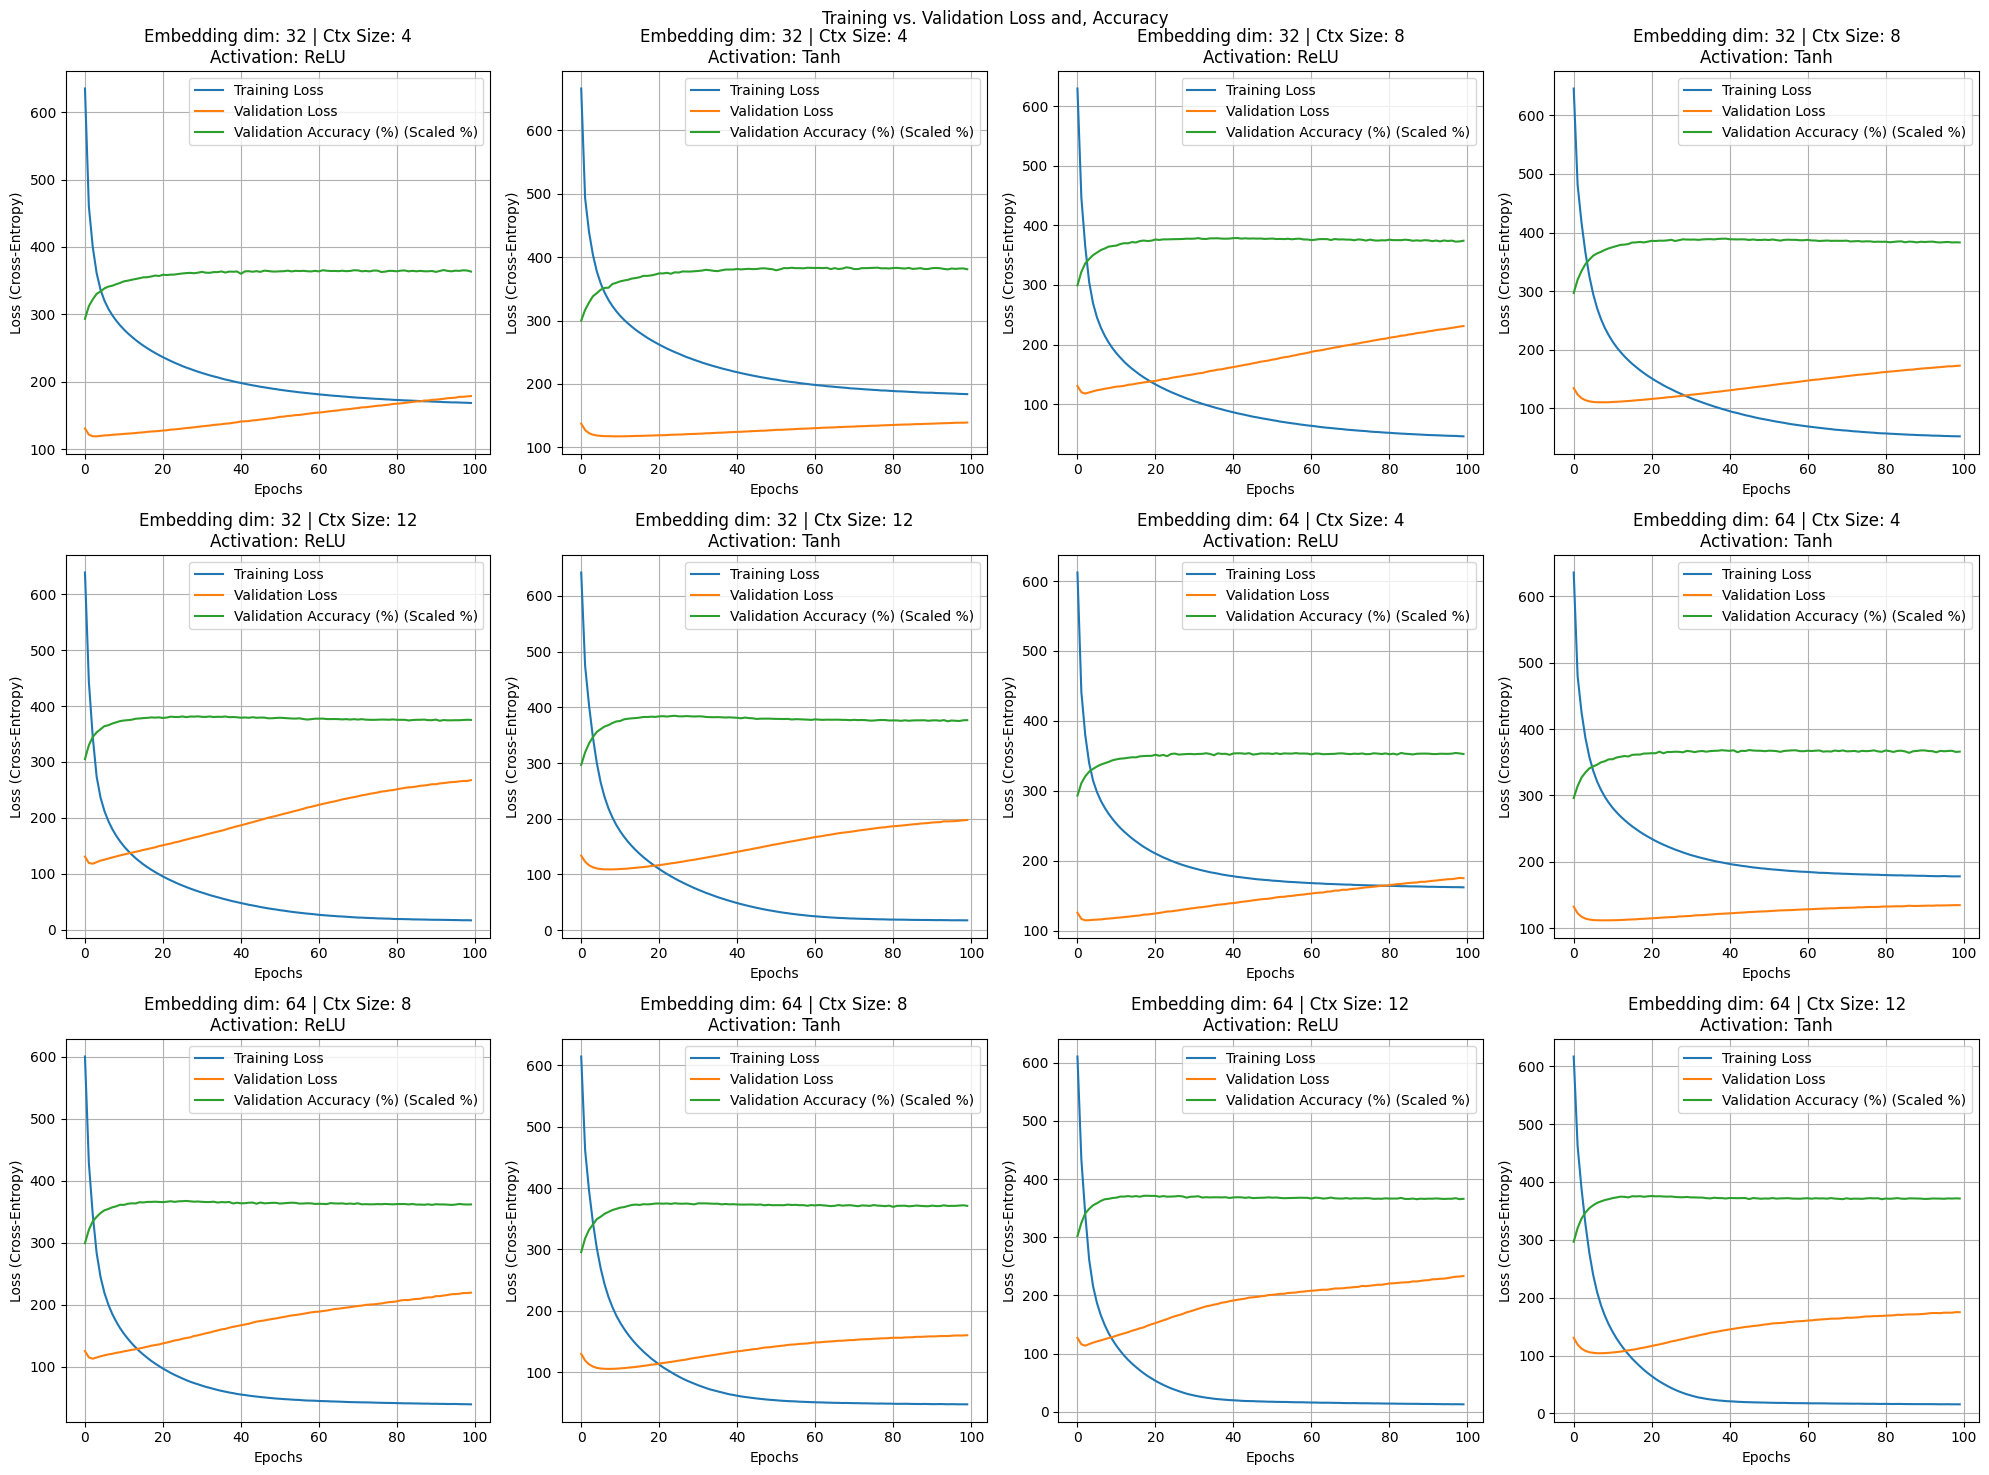

In [47]:
def plot(log = False):
    plt.figure(figsize=(20,15))
    for idx, (embedding_dim, ctx_sz,activation) in enumerate(itertools.product(embeddimg_dims,context_size,activations),1):
        plt.subplot(3,4,idx)
        with open(f'./saved_models_q1_2/e{embedding_dim}_c{ctx_sz}_a{activation._get_name()}_arrays.json','r') as f:
            data = json.load(f)
            tr_lss_arr = data['train_loss']
            val_lss_arr = data['val_loss']
            val_acc_arr = data['val_acc']
        plt.plot(tr_lss_arr, label='Training Loss')
        plt.plot(val_lss_arr, label='Validation Loss')
        plt.plot(np.array(val_acc_arr)/100 * max(np.max(tr_lss_arr),np.max(val_lss_arr)),label='Validation Accuracy (%) (Scaled %)')
        plt.title(f'Embedding dim: {embedding_dim} | Ctx Size: {ctx_sz}\nActivation: {activation._get_name()}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Cross-Entropy)')
        if log:
            plt.yscale('log')
        plt.legend()
        plt.grid(True)
    plt.suptitle('Training vs. Validation Loss and, Accuracy')
    plt.tight_layout()
    plt.show()
plot()

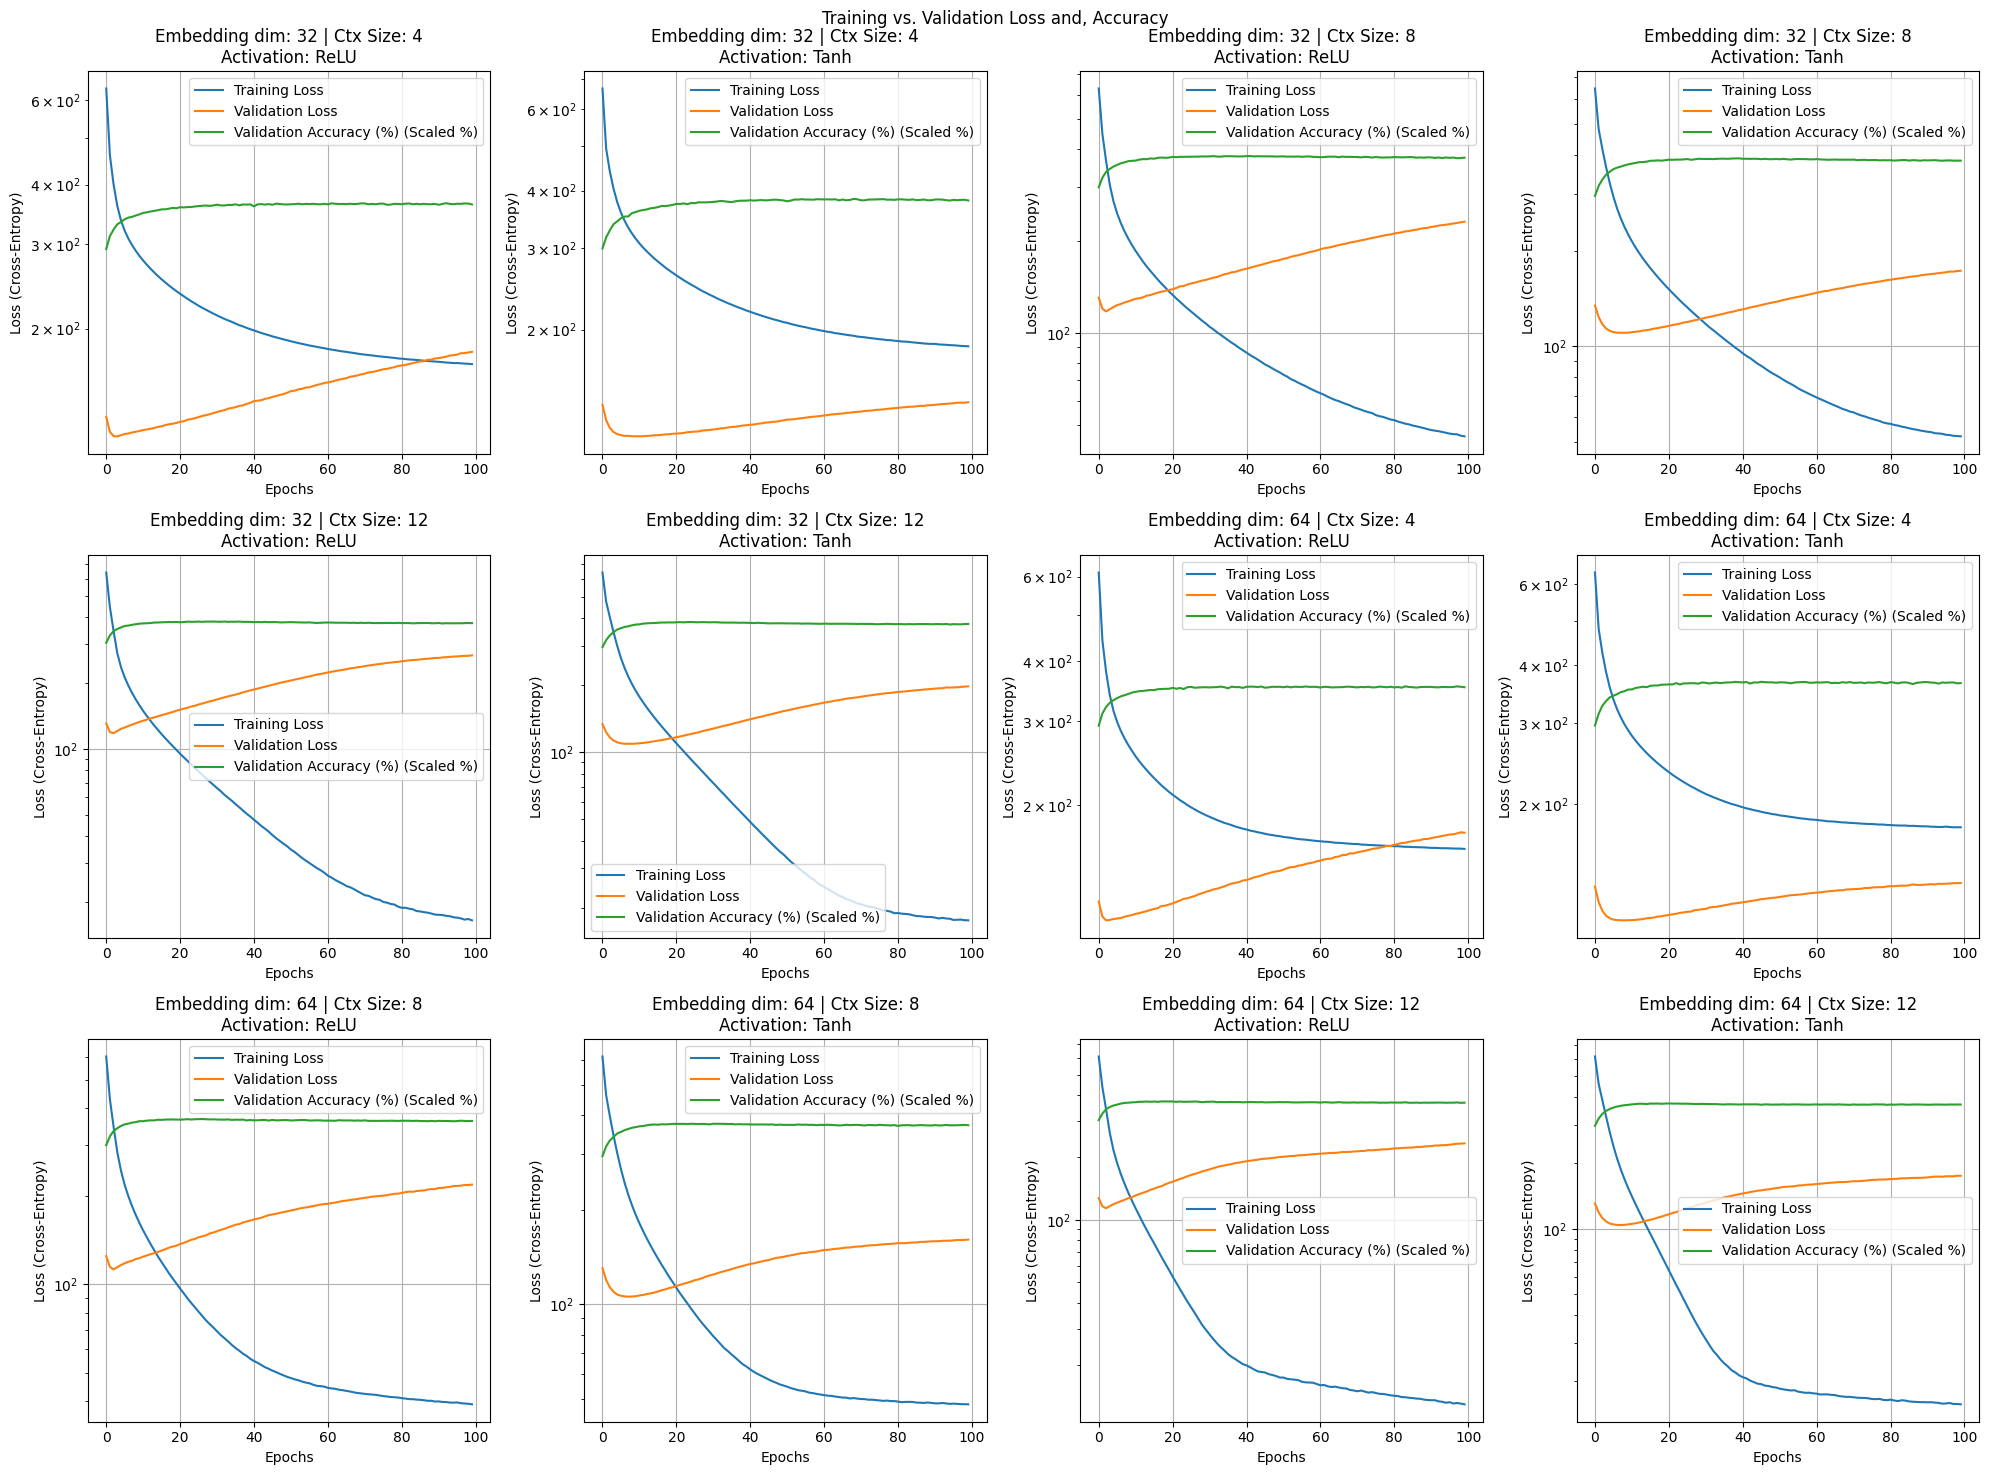

In [48]:
plot(True)

#### Best Model Category 2

In [35]:
best_overall_path = None
best_val_loss = float('inf')
for k,v in datas.items():
    if min(v['val_loss']) < best_val_loss:
        best_val_loss = min(v['val_loss'])
        best_overall_path = k
best_overall_path = best_overall_path.replace('_arrays.json', '_best.pth')
best_overall_path

'./saved_models_q1_2/e64_c12_aTanh_best.pth'

C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_24588\4095569035.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_overall_path, ma

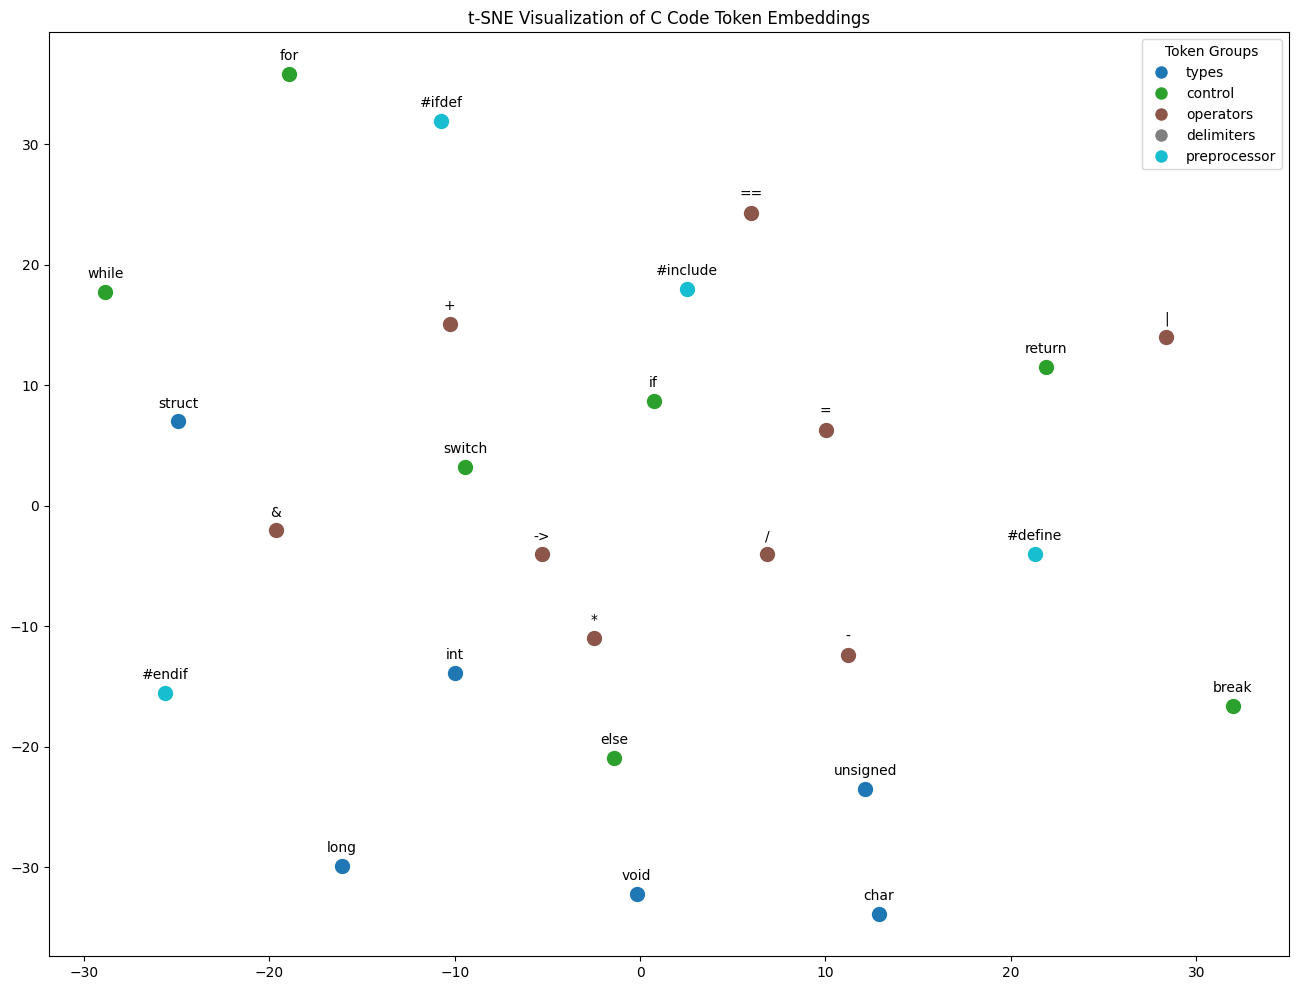

In [36]:
best_model = MLPTextGenerator(vocab_size, 64, 768, 12, nn.Tanh()).to(device)
best_model.load_state_dict(torch.load(best_overall_path, map_location='cpu'))
best_model.to(device)
best_model.eval()
visualize_code_embeddings(best_model,stoi)

## 1.5 Comparative Analysis [1 mark]